<h1> 2021-2 캡스톤 디자인 </h1>  


<h3>목표 : 대출량 예측 및 우선 대출 도서 선정 모델 개발</h3>  

데이터 수집 :  
1.도서관 정보나루 API 에서 국립세종도서관의 대출 데이터 수집  
2.국립중앙도서관 Open API에서 서지정보 수집 

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import logging
tf.get_logger().setLevel(logging.ERROR)
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import json
from urllib.request import urlopen, Request
import urllib
import requests
import re
from konlpy.tag import Okt
from gensim import models
import time
from tqdm import trange
from PIL import Image
import joblib
from collections import Counter
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import train_test_split 
import xgboost as xgb
import umap
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from transformers import *
from tqdm import tqdm
from tokenization_kobert import KoBertTokenizer
from focal_loss import SparseCategoricalFocalLoss
from sklearn.utils import shuffle
from transformers import *
import gc

C:\Users\soymi\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\soymi\anaconda3\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


<h1>여기서 주제 다시 확실히잡고감.</h1>  

<h3>1.도서관정보나루 모든 도서관 2021년 대출 데이터를 대상으로 할 것임.</h3>  

<h3>2.서지정보를 바탕으로 해당 책을 가장 많이 빌린 세대를 예측하는 모형 개발 -> 해당 모형에 가장 큰 영향을 주는 요소를 확인해봄</h3>

In [10]:
#모든 공공도서관에서 2021년 대출데이터를 긁어올것임(2021 01 01 ~ 2021 10 01)
with open('공공도서관코드.txt') as f:
    content = f.readlines()
publibcode = [x.replace('\n','') for x in content]

In [11]:
def get_loan_data(c):
    import requests
    import pandas as pd
    import os.path                      
    
    jn_key = '' ###
    file = f'C:\\Users\\soymi\\Desktop\\lib_git\\2021-2Capstonedesign\\api_data\\{c}.csv' 
    
    if os.path.isfile(file):
        pass
    else:
        isbn = []
        libcode = []
        reg_date = []

        url = f'http://data4library.kr/api/itemSrch?&libCode={c}&authKey={jn_key}&pageNo=1&pageSize=10&format=json&startDt=2021-01-01&endDt=2021-10-01'
        try:
            res = requests.get(url).json()
            pc = res['response']['numFound'] // 10
            re = res['response']['numFound'] % 10
        except:
            return(c)
        
        if pc == 1:
            try:
                url = f'http://data4library.kr/api/itemSrch?libCode={c}&authKey={jn_key}&pageNo=1&pageSize=10&format=json&startDt=2021-01-01&endDt=2021-10-01'
                res = requests.get(url).json()
                for j in res['response']['docs']:
                    libcode.append(c)
                    isbn.append(j['doc']['isbn13'])
                    reg_date.append(j['doc']['reg_date'])
            except:
                pass
        elif re == 0:
            for pgn in range(1,pc+1):
                try:
                    url = f'http://data4library.kr/api/itemSrch?libCode={c}&authKey={jn_key}&pageNo={pgn}&pageSize=10&format=json&startDt=2021-01-01&endDt=2021-10-01'
                    res = requests.get(url).json()
                    for j in res['response']['docs']:
                        libcode.append(c)
                        isbn.append(j['doc']['isbn13'])
                        reg_date.append(j['doc']['reg_date'])
                except:
                    pass

        else:
            for pgn in range(1,pc+2):
                try:
                    url = f'http://data4library.kr/api/itemSrch?libCode={c}&authKey={jn_key}&pageNo={pgn}&pageSize=10&format=json&startDt=2021-01-01&endDt=2021-10-01'
                    res = requests.get(url).json()
                    for j in res['response']['docs']:
                        libcode.append(c)
                        isbn.append(j['doc']['isbn13'])
                        reg_date.append(j['doc']['reg_date'])
                except:
                    pass

        result = pd.DataFrame({'libcode' : libcode, 'isbn' : isbn, 'reg_date' : reg_date})
        result.to_csv(f'./api_data/{c}.csv', index = False)

In [12]:
from tqdm.contrib.concurrent import process_map
import mp_worker as worker

if __name__ == '__main__':
    a = process_map(worker.get_loan_data, publibcode) 

  0%|          | 0/846 [00:00<?, ?it/s]

In [13]:
import pandas as pd
from tqdm import trange

for i in trange(len(publibcode)):
    if i == 0:
        c = publibcode[i]
        res = pd.read_csv(f'./api_data/{c}.csv')
    else:
        try:
            c = publibcode[i]
            temp = pd.read_csv(f'./api_data/{c}.csv')
            res = pd.concat([res, temp])
        except:
            print(c)

 54%|███████████████████████████████████████████▌                                    | 461/846 [00:44<00:56,  6.85it/s]

131496


100%|████████████████████████████████████████████████████████████████████████████████| 846/846 [02:23<00:00,  5.90it/s]


In [14]:
res

libcode           isbn    reg_date
0      127058  9788989111535  2021-10-01
1      127058  9788989111542  2021-10-01
2      127058  9788949161471  2021-08-31
3      127058  9791196845568  2021-08-25
4      127058  9791196845575  2021-08-25
...       ...            ...         ...
10945  141541  9791157769568  2021-01-11
10946  141541  9791197251511  2021-01-11
10947  141541  9791186259948  2021-01-11
10948  141541  9791166032738  2021-01-11
10949  141541  9791189816094  2021-01-11

[4196622 rows x 3 columns]

In [15]:
isbn = res.isbn.unique()
len(isbn)

380869

In [16]:
def get_info_from_isbn(isbn):
    
    import requests
    import pandas as pd
    import json
    import numpy as np
    
    oa_key = '' ###
    jn_key = '' ###


    try:
        url = f'http://seoji.nl.go.kr/landingPage/SearchApi.do?cert_key={oa_key}&isbn={i}&result_style=json&page_size=1&page_no=1'
        res = requests.get(url).json()
        url2 = f'http://data4library.kr/api/usageAnalysisList?authKey={jn_key}&format=json&isbn13={i}'
        res2 = requests.get(url2).json()
    except:
        return([isbn, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    
    
    ############
    
    
    try:
        title = res['docs'][0]['TITLE']
    except:
        title = np.nan
    
    try:
        if res['docs'][0]['TITLE_URL'] == '':
            title_image_url = res2['response']['book']['bookImageURL']
        else:
            title_image_url = res['docs'][0]['TITLE_URL']
    except:
        title_image_url = np.nan
    
    try:
        pages = res['docs'][0]['PAGE']
        if pages == '':
            pages = np.nan
    except:
        pages = np.nan
    
    try:
        major_subject = res['docs'][0]['SUBJECT']
        if major_subject == '':
            major_subject = np.nan
    except:
        major_subject = np.nan
        
    try:
        author = res['docs'][0]['AUTHOR']
        if author == '':
            author = np.nan
    except:
        author = np.nan
    
    try:
        target_1 = res2['response']['loanGrps'][0]['loanGrp']['age']
        target_2 = res2['response']['loanGrps'][0]['loanGrp']['gender']
    except:
        target_1 = np.nan
        target_2 = np.nan
    
    try:
        description = res2['response']['book']['description']
    except:
        description = np.nan
    
    return([isbn, title, title_image_url, pages, major_subject, author, description, target_1, target_2])

In [17]:
from tqdm.contrib.concurrent import process_map
import mp_worker as worker

if __name__ == '__main__':
    a = process_map(worker.get_info_from_isbn, isbn, max_workers = 16, chunksize = 1)

  0%|          | 0/380869 [00:00<?, ?it/s]

In [18]:
res = pd.DataFrame(a, columns = ['isbn','title','image_url', 'pages', 'major_subject', 'author', 'description', 'target_1', 'target_2'])

In [19]:
res.to_csv('raw_data.csv', index = False)

In [20]:
import pandas as pd
import numpy as np
data = pd.read_csv('raw_data.csv', dtype = {'isbn' : 'object'})

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380869 entries, 0 to 380868
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   isbn           380869 non-null  object 
 1   title          285706 non-null  object 
 2   image_url      249183 non-null  object 
 3   pages          167652 non-null  object 
 4   major_subject  274780 non-null  float64
 5   author         283544 non-null  object 
 6   description    266459 non-null  object 
 7   target_1       8265 non-null    object 
 8   target_2       8265 non-null    object 
dtypes: float64(1), object(8)
memory usage: 26.2+ MB


<h3>Data preprocessing</h3>  

1.isbn duplicated 제거

2.Title의 NA 제거 : 생성하기 힘듬.  

3.Subject,pages NA 제거 : 굳이만들려면 만들수있긴한데 준지도학습인만큼 확실하게하고싶음.  

4.author에서 지음/지은 포함여부로 번역서 여부 컬럼 추가 후 author 제거  

5.Description제거. 처음엔 사용할랬는데 목적이랑 좀 안맞는거같음.  

6.image_url의 na제거, image_url 이용 image를 다 받아오고 EffNet으로 돌린 후 결과 벡터를 join하고 isbn, image_url 삭제  

7.title을 BERT를 이용, 임베딩벡터로 변환한 뒤 title을 임베딩벡터로 교체  

8.major_subject ohe  

9.pages standarization -> scaler 저장  





In [22]:
#1 isbn duplicated 제거
data = data.drop_duplicates('isbn')
data

isbn            title  \
0       9788989111535         십자가와 수술칼   
1       9788989111542       한 알의 밀알 되어   
2       9788949161471      엠마는 최고의 멋쟁이   
3       9791196845568         부산민주운동사1   
4       9791196845575         부산민주운동사2   
...               ...              ...   
380864  9788932817897               생명   
380865  9788989968108      북아트를 통한 글쓰기   
380866  9788934122241       하나님 나라의 경제   
380867  9788989968733              NaN   
380868  9788980974344  오랑캐 홍타이지 천하를 얻다   

                                                image_url   pages  \
0                                                     NaN     464   
1                                                     NaN     630   
2       https://bookthumb-phinf.pstatic.net/cover/068/...     NaN   
3                                                     NaN     455   
4                                                     NaN     560   
...                                                   ...     ...   
380864  https://image.aladin.co.kr/product/25812/13/co...     NaN   
380865  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     248   
380866  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  168 p.   
380867                                                NaN     NaN   
380868  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  416 p.   

        major_subject                          author  \
0                 2.0                 저자 : 도널드 R. 플레처   
1                 2.0                  저자 : 동산의료선교복지회   
2                 8.0  수지 모건스턴 글 ;세브린 코르디에 그림 ;이세진 옮김   
3                 9.0                        저자 : 홍순권   
4                 9.0                        저자 : 홍순권   
...               ...                             ...   
380864            NaN        지은이: 한기수,백은찬,신전수,전우택,최종태   
380865            6.0                       저자 : 폴 존슨   
380866            2.0                           백순 지음   
380867            NaN                             NaN   
380868            9.0                          장한식 지음   

                                              description target_1 target_2  
0                                                     NaN      NaN      NaN  
1                                                     NaN      NaN      NaN  
2       난 책읽기가 좋아 시리즈 1단계 37권. 「엠마」시리즈는 수지 모건스턴의 손녀 이야...      NaN      NaN  
3                                                     NaN      NaN      NaN  
4                                                     NaN      NaN      NaN  
...                                                   ...      ...      ...  
380864  기독교 세계관 성경공부 시리즈 4권 『생명』에서는 하나님의 형상으로 지음받은 인간 ...      NaN      NaN  
380865  로버트 사부다의 화려한 팝업북 를 본 독자라면, 보는 순간 탄성을 지르게 하는 이런...      NaN      NaN  
380866  저자는 1960년대 말 도미하여, 경제학자로서 성장하여 최근까지 교수를 역임했다. ...      NaN      NaN  
380867  ‘책만들며 크는 학교’ 시리즈 22번째 책이다. 2000년 폴 존슨의 ‘메이킹북’을...      NaN      NaN  
380868  1억 대국을 정복한 100만 오랑캐 만주족의 성공 비결을 다룬 책. 저자는 400년...      NaN      NaN  

[363760 rows x 9 columns]

In [24]:
#title, subject, pages NA 제거  
data = data.loc[data.title.notna(),:]
data = data.loc[(data.pages.notna()) & (data.major_subject.notna()),:]
data

isbn                  title  \
0       9788989111535               십자가와 수술칼   
1       9788989111542             한 알의 밀알 되어   
3       9791196845568               부산민주운동사1   
4       9791196845575               부산민주운동사2   
6       9791195487363                  산호찜갈비   
...               ...                    ...   
380862  9788962228311      고사성어의 숨은 뜻을 찾아라 2   
380863  9788993267617  두뇌가 좋아지고 자존감이 커지는 말걸기   
380865  9788989968108            북아트를 통한 글쓰기   
380866  9788934122241             하나님 나라의 경제   
380868  9788980974344        오랑캐 홍타이지 천하를 얻다   

                                                image_url   pages  \
0                                                     NaN     464   
1                                                     NaN     630   
3                                                     NaN     455   
4                                                     NaN     560   
6                                                     NaN     142   
...                                                   ...     ...   
380862  http://image.aladin.co.kr/product/5739/57/cove...     192   
380863  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...    320p   
380865  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     248   
380866  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  168 p.   
380868  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  416 p.   

        major_subject                      author  \
0                 2.0             저자 : 도널드 R. 플레처   
1                 2.0              저자 : 동산의료선교복지회   
3                 9.0                    저자 : 홍순권   
4                 9.0                    저자 : 홍순권   
6                 3.0  기획자 : (재)대구광역시 중구 도심재생문화재단   
...               ...                         ...   
380862            3.0          김부일, 박강륵 글, 이우영 그림   
380863            3.0                         조하연   
380865            6.0                   저자 : 폴 존슨   
380866            2.0                       백순 지음   
380868            9.0                      장한식 지음   

                                              description target_1 target_2  
0                                                     NaN      NaN      NaN  
1                                                     NaN      NaN      NaN  
3                                                     NaN      NaN      NaN  
4                                                     NaN      NaN      NaN  
6                                                     NaN      NaN      NaN  
...                                                   ...      ...      ...  
380862  바른 정치의 중요성을 알려 주기 위해 고사성어를 빌려와 재미있는 만화로 설명한다. ...      NaN      NaN  
380863  0~36개월까지 촘촘하게 나누어서 각 발달 단계별로 아이의 언어 발달을 위해 부모가...      NaN      NaN  
380865  로버트 사부다의 화려한 팝업북 를 본 독자라면, 보는 순간 탄성을 지르게 하는 이런...      NaN      NaN  
380866  저자는 1960년대 말 도미하여, 경제학자로서 성장하여 최근까지 교수를 역임했다. ...      NaN      NaN  
380868  1억 대국을 정복한 100만 오랑캐 만주족의 성공 비결을 다룬 책. 저자는 400년...      NaN      NaN  

[155628 rows x 9 columns]

In [25]:
#옮김/옮긴 포함여부로 번역서 여부 컬럼 추가 후 author 제거  
data['translated'] = np.where([a or b for a,b in zip(data.author.str.contains('옮긴'), data.author.str.contains('옮김'))], 1, 0)
data = data.loc[:,[x for x in data.columns if x != 'author']]
data

<ipython-input-25-ad7745b2fe24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['translated'] = np.where([a or b for a,b in zip(data.author.str.contains('옮긴'), data.author.str.contains('옮김'))], 1, 0)


isbn                  title  \
0       9788989111535               십자가와 수술칼   
1       9788989111542             한 알의 밀알 되어   
3       9791196845568               부산민주운동사1   
4       9791196845575               부산민주운동사2   
6       9791195487363                  산호찜갈비   
...               ...                    ...   
380862  9788962228311      고사성어의 숨은 뜻을 찾아라 2   
380863  9788993267617  두뇌가 좋아지고 자존감이 커지는 말걸기   
380865  9788989968108            북아트를 통한 글쓰기   
380866  9788934122241             하나님 나라의 경제   
380868  9788980974344        오랑캐 홍타이지 천하를 얻다   

                                                image_url   pages  \
0                                                     NaN     464   
1                                                     NaN     630   
3                                                     NaN     455   
4                                                     NaN     560   
6                                                     NaN     142   
...                                                   ...     ...   
380862  http://image.aladin.co.kr/product/5739/57/cove...     192   
380863  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...    320p   
380865  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     248   
380866  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  168 p.   
380868  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  416 p.   

        major_subject                                        description  \
0                 2.0                                                NaN   
1                 2.0                                                NaN   
3                 9.0                                                NaN   
4                 9.0                                                NaN   
6                 3.0                                                NaN   
...               ...                                                ...   
380862            3.0  바른 정치의 중요성을 알려 주기 위해 고사성어를 빌려와 재미있는 만화로 설명한다. ...   
380863            3.0  0~36개월까지 촘촘하게 나누어서 각 발달 단계별로 아이의 언어 발달을 위해 부모가...   
380865            6.0  로버트 사부다의 화려한 팝업북 를 본 독자라면, 보는 순간 탄성을 지르게 하는 이런...   
380866            2.0  저자는 1960년대 말 도미하여, 경제학자로서 성장하여 최근까지 교수를 역임했다. ...   
380868            9.0  1억 대국을 정복한 100만 오랑캐 만주족의 성공 비결을 다룬 책. 저자는 400년...   

       target_1 target_2  translated  
0           NaN      NaN           0  
1           NaN      NaN           0  
3           NaN      NaN           0  
4           NaN      NaN           0  
6           NaN      NaN           0  
...         ...      ...         ...  
380862      NaN      NaN           0  
380863      NaN      NaN           0  
380865      NaN      NaN           0  
380866      NaN      NaN           0  
380868      NaN      NaN           0  

[155628 rows x 9 columns]

In [26]:
#Description제거. 처음엔 사용할랬는데 목적이랑 좀 안맞는거같음. 
data = data.loc[:,[x for x in data.columns if x != 'description']]
data

isbn                  title  \
0       9788989111535               십자가와 수술칼   
1       9788989111542             한 알의 밀알 되어   
3       9791196845568               부산민주운동사1   
4       9791196845575               부산민주운동사2   
6       9791195487363                  산호찜갈비   
...               ...                    ...   
380862  9788962228311      고사성어의 숨은 뜻을 찾아라 2   
380863  9788993267617  두뇌가 좋아지고 자존감이 커지는 말걸기   
380865  9788989968108            북아트를 통한 글쓰기   
380866  9788934122241             하나님 나라의 경제   
380868  9788980974344        오랑캐 홍타이지 천하를 얻다   

                                                image_url   pages  \
0                                                     NaN     464   
1                                                     NaN     630   
3                                                     NaN     455   
4                                                     NaN     560   
6                                                     NaN     142   
...                                                   ...     ...   
380862  http://image.aladin.co.kr/product/5739/57/cove...     192   
380863  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...    320p   
380865  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     248   
380866  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  168 p.   
380868  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  416 p.   

        major_subject target_1 target_2  translated  
0                 2.0      NaN      NaN           0  
1                 2.0      NaN      NaN           0  
3                 9.0      NaN      NaN           0  
4                 9.0      NaN      NaN           0  
6                 3.0      NaN      NaN           0  
...               ...      ...      ...         ...  
380862            3.0      NaN      NaN           0  
380863            3.0      NaN      NaN           0  
380865            6.0      NaN      NaN           0  
380866            2.0      NaN      NaN           0  
380868            9.0      NaN      NaN           0  

[155628 rows x 8 columns]

In [27]:
#image_url의 na제거, image_url 이용 image를 다 받아오고 EffNet으로 돌린 후 결과 벡터를 join하고 isbn, image_url 삭제
data = data.loc[data.image_url.notna(),:]
data

isbn                      title  \
19      9791160023176  주린이가 가장 알고 싶은 최다질문 top 77   
21      9788965964230             어떤 죽음이 삶에게 말했다   
22      9791190052733                    인터폴의 세계   
33      9791197472510            지쳤거나 좋아하는 게 없거나   
35      9791197239045          여성, 국채보상운동 나래를 펴다   
...               ...                        ...   
380862  9788962228311          고사성어의 숨은 뜻을 찾아라 2   
380863  9788993267617      두뇌가 좋아지고 자존감이 커지는 말걸기   
380865  9788989968108                북아트를 통한 글쓰기   
380866  9788934122241                 하나님 나라의 경제   
380868  9788980974344            오랑캐 홍타이지 천하를 얻다   

                                                image_url   pages  \
19      https://image.aladin.co.kr/product/26004/14/co...  388 p.   
21      http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  261 p.   
22      http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  375 p.   
33      http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     340   
35      http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  241 p.   
...                                                   ...     ...   
380862  http://image.aladin.co.kr/product/5739/57/cove...     192   
380863  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...    320p   
380865  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     248   
380866  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  168 p.   
380868  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...  416 p.   

        major_subject target_1 target_2  translated  
19                3.0      40대       여성           0  
21                8.0      40대       여성           0  
22                3.0      NaN      NaN           0  
33                8.0   60대 이상       여성           0  
35                9.0      NaN      NaN           0  
...               ...      ...      ...         ...  
380862            3.0      NaN      NaN           0  
380863            3.0      NaN      NaN           0  
380865            6.0      NaN      NaN           0  
380866            2.0      NaN      NaN           0  
380868            9.0      NaN      NaN           0  

[136322 rows x 8 columns]

In [28]:
image_url_isbn = list(zip(data.image_url, data.isbn))
import os

def get_image(z):
    if os.path.isfile(f'./image/{z[1]}.jpg'):
        return z[1]

    try:
        urllib.request.urlretrieve(z[0], f'./image/{z[1]}.jpg')
        return z[1]
    except:
        return np.nan

image_avail_isbn = []
for l in tqdm(image_url_isbn):
    image_avail_isbn.append(get_image(l))

100%|████████████████████████████████████████████████████████████████████████| 136322/136322 [00:18<00:00, 7253.84it/s]


In [29]:
len([x for x in image_avail_isbn if x != np.nan])

136322

In [30]:
image_list = []
image_isbn = []
for isbn in tqdm(image_avail_isbn):
    try:
        img = tf.keras.preprocessing.image.load_img(f'C:/Users/soymi/Desktop/lib_git/2021-2Capstonedesign/image/{isbn}.jpg', target_size = (64, 64))
        img_a = np.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis = 0)
        img_a = tf.keras.applications.efficientnet.preprocess_input(img_a)
        image_list.append(img_a)
        image_isbn.append(isbn)
    except:
        continue
        
image_list = np.concatenate(image_list)

  4%|██▉                                                                         | 5196/136322 [01:02<27:54, 78.30it/s]C:\Users\soymi\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (157019993 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
  5%|████                                                                       | 7332/136322 [01:26<18:22, 116.98it/s]C:\Users\soymi\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (97542144 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
  6%|████▋                                                                       | 8420/136322 [01:42<41:24, 51.48it/s]C:\Users\soymi\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (126802270 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
  7%|█████▎      

In [2]:
tf.random.set_seed(42)
effnetb4 = tf.keras.applications.EfficientNetB4(weights = 'imagenet', include_top = False, input_shape = (64,64,3))
res = effnetb4.output
res = tf.keras.layers.GlobalAveragePooling2D()(res)
model = tf.keras.Model(inputs = effnetb4.input, outputs = res)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate=.01), metrics = ['accuracy'])

In [4]:
model.save('effb4.h5')

C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [32]:
image_eff_res = model.predict(image_list)

In [39]:
eff_res = pd.DataFrame(image_eff_res)

In [44]:
eff_res['isbn'] = image_isbn
data = pd.merge(data, eff_res, left_on='isbn', right_on='isbn', how = 'inner')
data = data.loc[:,[x for x in data.columns if x != 'image_url']]
data

isbn                      title   pages  major_subject  \
0       9791160023176  주린이가 가장 알고 싶은 최다질문 top 77  388 p.            3.0   
1       9791197239045          여성, 국채보상운동 나래를 펴다  241 p.            9.0   
2       9788936477769                     강제이주열차  206 p.            8.0   
3       9791189809164                   안중근 안쏠로지  275 p.            9.0   
4       9791160946918                   어린이라는 세계  259 p.            8.0   
...               ...                        ...     ...            ...   
136200  9788962228311          고사성어의 숨은 뜻을 찾아라 2     192            3.0   
136201  9788993267617      두뇌가 좋아지고 자존감이 커지는 말걸기    320p            3.0   
136202  9788989968108                북아트를 통한 글쓰기     248            6.0   
136203  9788934122241                 하나님 나라의 경제  168 p.            2.0   
136204  9788980974344            오랑캐 홍타이지 천하를 얻다  416 p.            9.0   

       target_1 target_2  translated         0         1         2  ...  \
0           40대       여성           0 -0.145189 -0.086672  0.358043  ...   
1           NaN      NaN           0  0.001774 -0.093410 -0.102149  ...   
2           NaN      NaN           0 -0.125056  0.059235  0.019612  ...   
3           NaN      NaN           0 -0.242182 -0.037108  0.148868  ...   
4           30대       여성           0  0.256594 -0.053654 -0.247573  ...   
...         ...      ...         ...       ...       ...       ...  ...   
136200      NaN      NaN           0 -0.115741 -0.174070 -0.049711  ...   
136201      NaN      NaN           0 -0.231441 -0.201146 -0.035639  ...   
136202      NaN      NaN           0  0.217290  0.044647 -0.234834  ...   
136203      NaN      NaN           0 -0.232026 -0.044282  0.098957  ...   
136204      NaN      NaN           0 -0.093436 -0.226737 -0.153071  ...   

            1782      1783      1784      1785      1786      1787      1788  \
0      -0.041988 -0.264125 -0.229941  0.025920 -0.136360 -0.164008 -0.237162   
1       0.132511 -0.275120 -0.230950  0.229203 -0.275666 -0.039889  0.208425   
2       0.263252 -0.255381 -0.266850 -0.102699 -0.117357  0.011403  0.050987   
3       0.183148 -0.270722 -0.254286  0.539617 -0.134875 -0.126212  0.061990   
4      -0.071309 -0.267088 -0.263650  0.101112 -0.207741 -0.138664 -0.218825   
...          ...       ...       ...       ...       ...       ...       ...   
136200  0.095331 -0.094996 -0.263884 -0.062565 -0.203309 -0.065627 -0.259833   
136201  0.003128 -0.271030 -0.224856  0.075999 -0.219533 -0.074412 -0.187844   
136202 -0.058580 -0.272042 -0.273142 -0.191218 -0.105012 -0.174441 -0.270956   
136203 -0.193318 -0.215460 -0.232809 -0.033802 -0.268450  0.192240  0.243548   
136204 -0.037725 -0.276283 -0.260582 -0.073473 -0.243096 -0.231562 -0.227389   

            1789      1790      1791  
0      -0.073280 -0.237294 -0.263546  
1      -0.177260 -0.232512 -0.234672  
2      -0.266281 -0.167787 -0.137343  
3      -0.262636 -0.263175 -0.081808  
4      -0.240917 -0.275419  0.116658  
...          ...       ...       ...  
136200 -0.214883 -0.150531 -0.021071  
136201  0.155875 -0.056664 -0.250156  
136202 -0.195876 -0.151916 -0.269166  
136203 -0.256948 -0.026819 -0.233922  
136204 -0.223977 -0.224550 -0.204468  

[136205 rows x 1799 columns]

In [ ]:
#ram부담이 너무커쳐서 한번 save하고 감.
data.to_csv('preprocess_1.csv', index = False)

In [3]:
data = pd.read_csv('preprocess_1.csv')

C:\Users\soymi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
data

isbn                      title   pages  major_subject  \
0       9791160023176  주린이가 가장 알고 싶은 최다질문 top 77  388 p.            3.0   
1       9791197239045          여성, 국채보상운동 나래를 펴다  241 p.            9.0   
2       9788936477769                     강제이주열차  206 p.            8.0   
3       9791189809164                   안중근 안쏠로지  275 p.            9.0   
4       9791160946918                   어린이라는 세계  259 p.            8.0   
...               ...                        ...     ...            ...   
136200  9788962228311          고사성어의 숨은 뜻을 찾아라 2     192            3.0   
136201  9788993267617      두뇌가 좋아지고 자존감이 커지는 말걸기    320p            3.0   
136202  9788989968108                북아트를 통한 글쓰기     248            6.0   
136203  9788934122241                 하나님 나라의 경제  168 p.            2.0   
136204  9788980974344            오랑캐 홍타이지 천하를 얻다  416 p.            9.0   

       target_1 target_2  translated         0         1         2  ...  \
0           40대       여성           0 -0.145189 -0.086672  0.358043  ...   
1           NaN      NaN           0  0.001774 -0.093410 -0.102149  ...   
2           NaN      NaN           0 -0.125056  0.059235  0.019612  ...   
3           NaN      NaN           0 -0.242182 -0.037108  0.148868  ...   
4           30대       여성           0  0.256594 -0.053654 -0.247573  ...   
...         ...      ...         ...       ...       ...       ...  ...   
136200      NaN      NaN           0 -0.115741 -0.174070 -0.049711  ...   
136201      NaN      NaN           0 -0.231441 -0.201146 -0.035639  ...   
136202      NaN      NaN           0  0.217290  0.044647 -0.234834  ...   
136203      NaN      NaN           0 -0.232026 -0.044282  0.098957  ...   
136204      NaN      NaN           0 -0.093436 -0.226737 -0.153071  ...   

            1782      1783      1784      1785      1786      1787      1788  \
0      -0.041988 -0.264125 -0.229940  0.025920 -0.136360 -0.164008 -0.237162   
1       0.132511 -0.275120 -0.230950  0.229203 -0.275666 -0.039889  0.208425   
2       0.263252 -0.255381 -0.266850 -0.102699 -0.117357  0.011403  0.050987   
3       0.183148 -0.270722 -0.254287  0.539617 -0.134875 -0.126212  0.061990   
4      -0.071309 -0.267088 -0.263650  0.101112 -0.207741 -0.138664 -0.218825   
...          ...       ...       ...       ...       ...       ...       ...   
136200  0.095331 -0.094996 -0.263884 -0.062565 -0.203309 -0.065627 -0.259833   
136201  0.003128 -0.271030 -0.224856  0.075999 -0.219533 -0.074412 -0.187844   
136202 -0.058580 -0.272042 -0.273142 -0.191218 -0.105012 -0.174441 -0.270956   
136203 -0.193318 -0.215460 -0.232809 -0.033802 -0.268450  0.192240  0.243548   
136204 -0.037725 -0.276283 -0.260582 -0.073473 -0.243096 -0.231562 -0.227389   

            1789      1790      1791  
0      -0.073280 -0.237294 -0.263546  
1      -0.177259 -0.232512 -0.234672  
2      -0.266281 -0.167787 -0.137343  
3      -0.262636 -0.263175 -0.081808  
4      -0.240917 -0.275419  0.116658  
...          ...       ...       ...  
136200 -0.214883 -0.150531 -0.021071  
136201  0.155875 -0.056664 -0.250156  
136202 -0.195876 -0.151916 -0.269166  
136203 -0.256948 -0.026819 -0.233922  
136204 -0.223977 -0.224550 -0.204468  

[136205 rows x 1799 columns]

In [5]:
#title을 bert를 이용해 vector로 변환한 후 title 삭제
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

def check_max_length(X):
    a = [len(tokenizer.encode(x, add_special_tokens=True)) for x in X]
    return max(a)

def title_to_feature(X, max_seq):
    global tokenizer
    tokkens = []
    segments = []
    masks = []
    
    for title in tqdm(X):
        tokken = np.array(tokenizer.encode(title, max_length=max_seq, truncation=True, padding='max_length')).reshape(max_seq,)
        
        tokkens.append(tokken)
        segments.append(np.zeros(max_seq).astype(int))
        masks.append(np.where(tokken != 1, 1, 0))
        
    return [np.array(tokkens),np.array(masks) ,np.array(segments)]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [6]:
check_max_length(data.title)

95

In [7]:
X = title_to_feature(data.title, 128)

100%|████████████████████████████████████████████████████████████████████████| 136205/136205 [00:13<00:00, 9815.36it/s]


In [8]:
model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
token_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])[1]

title_to_vector = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], bert_outputs)

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
title_to_vector.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 92186880    input_word_ids[0][0]             
                                                                 input_masks[0][0]            

In [10]:
joblib.dump(title_to_vector, 'bert.json')

['bert.json']

In [11]:
res = title_to_vector.predict(X)

C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [12]:
res_df = pd.DataFrame(res)
res_df['isbn'] = data.isbn

In [13]:
res_df

0         1         2         3         4         5         6  \
0       0.011333 -0.015570  0.205580  0.061218  0.570356  0.349508 -0.768991   
1       0.030004 -0.042344  0.359385 -0.037350  0.258222  0.512084 -0.743298   
2      -0.005878 -0.007990  0.024224  0.002854  0.317771  0.757693 -0.756966   
3       0.015056 -0.016175  0.006049 -0.044519 -0.545527  0.933292 -0.687290   
4      -0.027033 -0.003583  0.076252  0.013988  0.259773  0.612979 -0.842279   
...          ...       ...       ...       ...       ...       ...       ...   
136200  0.018536 -0.015301  0.111209 -0.047048 -0.300942  0.928348 -0.649080   
136201  0.068608 -0.048790  0.404119  0.048623  0.886939 -0.492444 -0.675682   
136202  0.041476 -0.062401  0.145808 -0.031207  0.378512  0.604142 -0.752226   
136203  0.059722  0.022423 -0.312078 -0.000480  0.119927  0.806811 -0.518876   
136204  0.027808 -0.037990 -0.188694  0.044664 -0.433674  0.952344  0.127402   

               7         8         9  ...       759       760       761  \
0       0.132750  0.038011 -0.061591  ... -0.700929 -0.784291 -0.922082   
1       0.138074 -0.037832 -0.062326  ... -0.948542 -0.695086 -0.677394   
2       0.110285 -0.030544 -0.040093  ...  0.295478 -0.017788 -0.718223   
3       0.113537 -0.003697 -0.027441  ... -0.233690  0.333530  0.514596   
4       0.118341 -0.045131 -0.060260  ...  0.605067  0.103612 -0.888192   
...          ...       ...       ...  ...       ...       ...       ...   
136200  0.131348 -0.011448 -0.086736  ... -0.926946 -0.478161 -0.153629   
136201  0.104634 -0.000865 -0.065688  ... -0.829609 -0.851051 -0.987883   
136202  0.094196 -0.005371 -0.011624  ... -0.182226 -0.243055 -0.795264   
136203  0.041947 -0.036402 -0.067145  ...  0.187170  0.214025 -0.366780   
136204  0.113473 -0.063472 -0.053133  ... -0.880080 -0.403832  0.652897   

             762       763       764       765       766       767  \
0       0.333911 -0.052952  0.998722  0.087588 -0.050577 -0.011613   
1       0.080969 -0.091574  0.980465  0.129695 -0.047150 -0.000982   
2       0.219724  0.069140  0.964535  0.057986 -0.033012  0.018888   
3      -0.397899  0.080113 -0.677103  0.037881 -0.066475  0.005017   
4       0.366708  0.017356  0.996558  0.056146 -0.032256  0.009573   
...          ...       ...       ...       ...       ...       ...   
136200 -0.050862 -0.050312  0.585879  0.077713 -0.051464 -0.001164   
136201  0.676671 -0.065467  0.999981  0.125511 -0.051764  0.039732   
136202  0.119671  0.028162  0.989506  0.094071 -0.052479  0.003308   
136203 -0.132285  0.094733  0.728891  0.032941  0.023949 -0.084525   
136204 -0.543438 -0.005863 -0.821230  0.073652 -0.024177  0.003467   

                 isbn  
0       9791160023176  
1       9791197239045  
2       9788936477769  
3       9791189809164  
4       9791160946918  
...               ...  
136200  9788962228311  
136201  9788993267617  
136202  9788989968108  
136203  9788934122241  
136204  9788980974344  

[136205 rows x 769 columns]

In [14]:
res_df.columns = [f'bert_{x}' if x != 'isbn' else x for x in res_df.columns]

In [15]:
data = data.merge(res_df, on='isbn')

In [16]:
data = data.loc[:, [x for x in data.columns if x != 'title']]

In [17]:
data

isbn   pages  major_subject target_1 target_2  translated  \
0       9791160023176  388 p.            3.0      40대       여성           0   
1       9791197239045  241 p.            9.0      NaN      NaN           0   
2       9788936477769  206 p.            8.0      NaN      NaN           0   
3       9791189809164  275 p.            9.0      NaN      NaN           0   
4       9791160946918  259 p.            8.0      30대       여성           0   
...               ...     ...            ...      ...      ...         ...   
136200  9788962228311     192            3.0      NaN      NaN           0   
136201  9788993267617    320p            3.0      NaN      NaN           0   
136202  9788989968108     248            6.0      NaN      NaN           0   
136203  9788934122241  168 p.            2.0      NaN      NaN           0   
136204  9788980974344  416 p.            9.0      NaN      NaN           0   

               0         1         2         3  ...  bert_758  bert_759  \
0      -0.145189 -0.086672  0.358043 -0.193554  ... -0.004750 -0.700929   
1       0.001774 -0.093410 -0.102149 -0.100729  ... -0.080808 -0.948542   
2      -0.125056  0.059235  0.019612 -0.256231  ...  0.003623  0.295478   
3      -0.242182 -0.037108  0.148868 -0.202181  ...  0.025114 -0.233690   
4       0.256594 -0.053654 -0.247573 -0.084676  ...  0.024281  0.605067   
...          ...       ...       ...       ...  ...       ...       ...   
136200 -0.115741 -0.174070 -0.049711 -0.225616  ...  0.000298 -0.926946   
136201 -0.231441 -0.201146 -0.035639 -0.256676  ... -0.010651 -0.829609   
136202  0.217290  0.044647 -0.234834 -0.255480  ...  0.002491 -0.182226   
136203 -0.232026 -0.044282  0.098957 -0.129511  ... -0.013843  0.187170   
136204 -0.093436 -0.226737 -0.153071 -0.263103  ... -0.054501 -0.880080   

        bert_760  bert_761  bert_762  bert_763  bert_764  bert_765  bert_766  \
0      -0.784291 -0.922082  0.333911 -0.052952  0.998722  0.087588 -0.050577   
1      -0.695086 -0.677394  0.080969 -0.091574  0.980465  0.129695 -0.047150   
2      -0.017788 -0.718223  0.219724  0.069140  0.964535  0.057986 -0.033012   
3       0.333530  0.514596 -0.397899  0.080113 -0.677103  0.037881 -0.066475   
4       0.103612 -0.888192  0.366708  0.017356  0.996558  0.056146 -0.032256   
...          ...       ...       ...       ...       ...       ...       ...   
136200 -0.478161 -0.153629 -0.050862 -0.050312  0.585879  0.077713 -0.051464   
136201 -0.851051 -0.987883  0.676671 -0.065467  0.999981  0.125511 -0.051764   
136202 -0.243055 -0.795264  0.119671  0.028162  0.989506  0.094071 -0.052479   
136203  0.214025 -0.366780 -0.132285  0.094733  0.728891  0.032941  0.023949   
136204 -0.403832  0.652897 -0.543438 -0.005863 -0.821230  0.073652 -0.024177   

        bert_767  
0      -0.011613  
1      -0.000982  
2       0.018888  
3       0.005017  
4       0.009573  
...          ...  
136200 -0.001164  
136201  0.039732  
136202  0.003308  
136203 -0.084525  
136204  0.003467  

[136205 rows x 2566 columns]

In [18]:
#major_subject ohe
res = pd.get_dummies(data.major_subject)
res['isbn'] = data.isbn

In [19]:
data = data.merge(res, on = 'isbn')
data = data.loc[:, [x for x in data.columns if x != 'major_subject']]

In [20]:
data

isbn   pages target_1 target_2  translated         0  \
0       9791160023176  388 p.      40대       여성           0 -0.145189   
1       9791197239045  241 p.      NaN      NaN           0  0.001774   
2       9788936477769  206 p.      NaN      NaN           0 -0.125056   
3       9791189809164  275 p.      NaN      NaN           0 -0.242182   
4       9791160946918  259 p.      30대       여성           0  0.256594   
...               ...     ...      ...      ...         ...       ...   
136200  9788962228311     192      NaN      NaN           0 -0.115741   
136201  9788993267617    320p      NaN      NaN           0 -0.231441   
136202  9788989968108     248      NaN      NaN           0  0.217290   
136203  9788934122241  168 p.      NaN      NaN           0 -0.232026   
136204  9788980974344  416 p.      NaN      NaN           0 -0.093436   

               1         2         3         4  ...  0.0  1.0  2.0  3.0  4.0  \
0      -0.086672  0.358043 -0.193554 -0.253301  ...    0    0    0    1    0   
1      -0.093410 -0.102149 -0.100729 -0.229225  ...    0    0    0    0    0   
2       0.059235  0.019612 -0.256231 -0.211159  ...    0    0    0    0    0   
3      -0.037108  0.148868 -0.202181 -0.223803  ...    0    0    0    0    0   
4      -0.053654 -0.247573 -0.084676 -0.260789  ...    0    0    0    0    0   
...          ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
136200 -0.174070 -0.049711 -0.225616 -0.088979  ...    0    0    0    1    0   
136201 -0.201146 -0.035639 -0.256676 -0.255045  ...    0    0    0    1    0   
136202  0.044647 -0.234834 -0.255480 -0.090442  ...    0    0    0    0    0   
136203 -0.044282  0.098957 -0.129511 -0.258105  ...    0    0    1    0    0   
136204 -0.226737 -0.153071 -0.263103 -0.265311  ...    0    0    0    0    0   

        5.0  6.0  7.0  8.0  9.0  
0         0    0    0    0    0  
1         0    0    0    0    1  
2         0    0    0    1    0  
3         0    0    0    0    1  
4         0    0    0    1    0  
...     ...  ...  ...  ...  ...  
136200    0    0    0    0    0  
136201    0    0    0    0    0  
136202    0    1    0    0    0  
136203    0    0    0    0    0  
136204    0    0    0    0    1  

[136205 rows x 2575 columns]

In [21]:
#9. pages 가져오고 standarization
def get_pages(x):
    x = re.findall(r'\d+', x)
    if x == []:
        return int(0)
    else:
        return int(max(x))
    
data.pages = data.pages.apply(get_pages)

In [22]:
#그리 정상적으로 보이진 않음 -> 2000넘는애들 2000으로 clip
data.loc[data.pages > 2000, :]

isbn  pages target_1 target_2  translated         0  \
31255   9791156880509   6700      NaN      NaN           0  0.217947   
35916   9791188946501   3021      NaN      NaN           0 -0.194688   
36488   9788994844527   2292      NaN      NaN           0 -0.255831   
39428   9788953723269   2064      NaN      NaN           0 -0.119227   
43130   9788937437410   2197      NaN      NaN           1 -0.200980   
47432   9788937461057   4552      NaN      NaN           0 -0.223033   
49853   9791187132295   2484      NaN      NaN           0 -0.022372   
50548   9788974331337   2850      NaN      NaN           0  0.155373   
61699   9791197467608   2900      NaN      NaN           1 -0.165482   
68569   9791160641899   2303      NaN      NaN           0 -0.189019   
70285   9788992621502   2400      NaN      NaN           0 -0.162408   
72210   9788964771266   2019      NaN      NaN           0 -0.136591   
75431   9788935664719   2034      NaN      NaN           1 -0.170125   
75432   9788935664764   3890      NaN      NaN           1 -0.172414   
75435   9788935664757   3274      NaN      NaN           1 -0.219295   
75437   9788935664733   2670      NaN      NaN           1 -0.228941   
77825   9788926385968   9500  유아(6~7)       남성           0 -0.247889   
85490   9788932321165   6000      NaN      NaN           0 -0.184931   
90449   9788932321196   4018      NaN      NaN           0 -0.076067   
91678   9791185952222   2288      NaN      NaN           0 -0.180676   
97234   9788932321189   2456      NaN      NaN           0 -0.135345   
101438  9788993858341   2392      NaN      NaN           0 -0.109875   
107954  9791197432521   2164      NaN      NaN           0 -0.059748   
107955  9791197432538   3224      NaN      NaN           0 -0.022346   
107956  9791197432545   4270      NaN      NaN           0 -0.039700   
108468  9791186172568   2168      NaN      NaN           0 -0.094358   
109413  9788909545181   2141      NaN      NaN           0 -0.099965   
109417  9788909542319   4488      NaN      NaN           0 -0.193137   
111217  9791189397074   2601      NaN      NaN           0 -0.216941   
113406  9788994844534   2167      NaN      NaN           0 -0.234581   
115882  9788953722521   2272      NaN      NaN           0 -0.017136   
117772  9791159160035   3000   60대 이상       남성           0 -0.199748   
121801  9791163060321   2052      NaN      NaN           0 -0.009487   
123757  9791186647011   4320      20대       여성           0 -0.251780   
133838  9791136740281   5500      NaN      NaN           0 -0.198865   

               1         2         3         4  ...  0.0  1.0  2.0  3.0  4.0  \
31255   0.138313  0.002375 -0.242819 -0.219422  ...    0    0    0    0    0   
35916  -0.266214 -0.137062 -0.274150 -0.270581  ...    0    0    0    1    0   
36488  -0.091018 -0.126367 -0.214376 -0.216304  ...    0    0    0    0    0   
39428  -0.245928  0.045062  0.239105 -0.272260  ...    0    0    1    0    0   
43130  -0.122238 -0.072793 -0.228917 -0.228300  ...    0    0    0    0    0   
47432  -0.144932 -0.213092 -0.270528 -0.260829  ...    0    0    0    0    0   
49853   0.031829 -0.062626 -0.236043 -0.216512  ...    0    0    0    1    0   
50548  -0.144982 -0.237385  0.043307 -0.261272  ...    0    0    0    0    0   
61699  -0.203403 -0.114967 -0.242168 -0.239323  ...    0    0    1    0    0   
68569  -0.264206  0.095924 -0.242026 -0.232792  ...    0    0    0    1    0   
70285  -0.001019 -0.024391 -0.000040 -0.227805  ...    0    0    0    0    0   
72210  -0.255830 -0.049645 -0.262492 -0.259414  ...    0    0    0    1    0   
75431   0.084839  0.058726 -0.102493 -0.202439  ...    1    0    0    0    0   
75432  -0.018462 -0.239158 -0.207832 -0.200027  ...    1    0    0    0    0   
75435  -0.072734  0.060856 -0.243524 -0.265006  ...    1    0    0    0    0   
75437  -0.156921 -0.067656 -0.198828 -0.254763  ...    1    0    0    0    0   
77825  -0.207692  0.044605 -0.242491 -0.220488  ...    0    0   

(array([5.2272e+04, 6.3801e+04, 1.5647e+04, 3.1770e+03, 8.5300e+02,
        2.4800e+02, 9.1000e+01, 4.8000e+01, 2.2000e+01, 4.6000e+01]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <BarContainer object of 10 artists>)

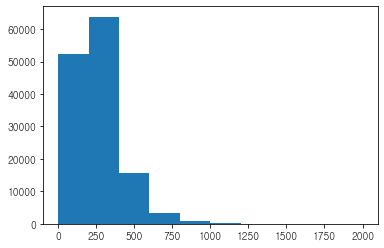

In [23]:
data.pages = data.pages.clip(upper=2000)

plt.hist(data.pages)

In [24]:
scaler_pages = StandardScaler()
data.pages = scaler_pages.fit_transform(data[['pages']]).flatten()

(array([5.2272e+04, 6.4395e+04, 1.5053e+04, 3.1770e+03, 8.5300e+02,
        2.4800e+02, 9.3000e+01, 4.7000e+01, 2.1000e+01, 4.6000e+01]),
 array([-1.53924732, -0.33307799,  0.87309134,  2.07926068,  3.28543001,
         4.49159934,  5.69776867,  6.903938  ,  8.11010733,  9.31627666,
        10.52244599]),
 <BarContainer object of 10 artists>)

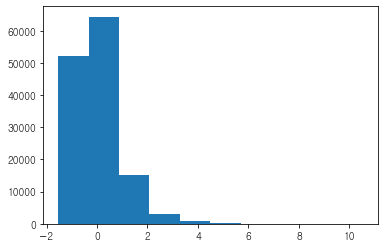

In [25]:
plt.hist(data.pages)

In [26]:
joblib.dump(scaler_pages, 'scaler_pages.pickle')

['scaler_pages.pickle']

In [27]:
data.target_1.value_counts()

40대           761
20대           660
50대           623
초등(8~13)      564
영유아(0~5)      452
60대 이상        417
30대           385
청소년(14~19)    371
유아(6~7)       267
Name: target_1, dtype: int64

In [28]:
#target을 2개의 변수로 나눠줌
def target_preprocess(target_1):
    if pd.isna(target_1):
        return np.nan
    elif target_1 in ['초등(8~13)', '영유아(0~5)', '유아(6~7)', '청소년(14~19)']:
        return int(0)
    elif target_1 == '60대 이상':
        return int(2)
    else:
        return int(1)
data['label'] = data.target_1.apply(target_preprocess)

In [29]:
data = data.loc[:, [x for x in data.columns if x not in ['target_1', 'target_2']]]
data

isbn     pages  translated         0         1         2  \
0       9791160023176  0.800721           0 -0.145189 -0.086672  0.358043   
1       9791197239045 -0.085813           0  0.001774 -0.093410 -0.102149   
2       9788936477769 -0.296893           0 -0.125056  0.059235  0.019612   
3       9791189809164  0.119236           0 -0.242182 -0.037108  0.148868   
4       9791160946918  0.022742           0  0.256594 -0.053654 -0.247573   
...               ...       ...         ...       ...       ...       ...   
136200  9788962228311 -0.381325           0 -0.115741 -0.174070 -0.049711   
136201  9788993267617  0.390624           0 -0.231441 -0.201146 -0.035639   
136202  9788989968108 -0.043597           0  0.217290  0.044647 -0.234834   
136203  9788934122241 -0.526065           0 -0.232026 -0.044282  0.098957   
136204  9788980974344  0.969585           0 -0.093436 -0.226737 -0.153071   

               3         4         5         6  ...  1.0  2.0  3.0  4.0  5.0  \
0      -0.193554 -0.253301 -0.024594  0.110316  ...    0    0    1    0    0   
1      -0.100729 -0.229225 -0.225267 -0.212020  ...    0    0    0    0    0   
2      -0.256231 -0.211159 -0.226081 -0.146266  ...    0    0    0    0    0   
3      -0.202181 -0.223803 -0.242821 -0.201433  ...    0    0    0    0    0   
4      -0.084676 -0.260789  0.014766  0.403906  ...    0    0    0    0    0   
...          ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
136200 -0.225616 -0.088979 -0.241837 -0.044052  ...    0    0    1    0    0   
136201 -0.256676 -0.255045 -0.023892  0.070428  ...    0    0    1    0    0   
136202 -0.255480 -0.090442 -0.224543 -0.184472  ...    0    0    0    0    0   
136203 -0.129511 -0.258105  0.106923  0.110444  ...    0    1    0    0    0   
136204 -0.263103 -0.265311  0.000753 -0.125928  ...    0    0    0    0    0   

        6.0  7.0  8.0  9.0  label  
0         0    0    0    0    1.0  
1         0    0    0    1    NaN  
2         0    0    1    0    NaN  
3         0    0    0    1    NaN  
4         0    0    1    0    1.0  
...     ...  ...  ...  ...    ...  
136200    0    0    0    0    NaN  
136201    0    0    0    0    NaN  
136202    1    0    0    0    NaN  
136203    0    0    0    0    NaN  
136204    0    0    0    1    NaN  

[136205 rows x 2574 columns]

In [30]:
data.label.value_counts()

1.0    2429
0.0    1654
2.0     417
Name: label, dtype: int64

In [31]:
#마지막으로 isbn 제거
data = data.loc[:, [x for x in data.columns if x != 'isbn']]

In [32]:
data

pages  translated         0         1         2         3  \
0       0.800721           0 -0.145189 -0.086672  0.358043 -0.193554   
1      -0.085813           0  0.001774 -0.093410 -0.102149 -0.100729   
2      -0.296893           0 -0.125056  0.059235  0.019612 -0.256231   
3       0.119236           0 -0.242182 -0.037108  0.148868 -0.202181   
4       0.022742           0  0.256594 -0.053654 -0.247573 -0.084676   
...          ...         ...       ...       ...       ...       ...   
136200 -0.381325           0 -0.115741 -0.174070 -0.049711 -0.225616   
136201  0.390624           0 -0.231441 -0.201146 -0.035639 -0.256676   
136202 -0.043597           0  0.217290  0.044647 -0.234834 -0.255480   
136203 -0.526065           0 -0.232026 -0.044282  0.098957 -0.129511   
136204  0.969585           0 -0.093436 -0.226737 -0.153071 -0.263103   

               4         5         6         7  ...  1.0  2.0  3.0  4.0  5.0  \
0      -0.253301 -0.024594  0.110316 -0.234782  ...    0    0    1    0    0   
1      -0.229225 -0.225267 -0.212020 -0.273705  ...    0    0    0    0    0   
2      -0.211159 -0.226081 -0.146266 -0.038898  ...    0    0    0    0    0   
3      -0.223803 -0.242821 -0.201433 -0.247672  ...    0    0    0    0    0   
4      -0.260789  0.014766  0.403906 -0.254010  ...    0    0    0    0    0   
...          ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
136200 -0.088979 -0.241837 -0.044052 -0.252661  ...    0    0    1    0    0   
136201 -0.255045 -0.023892  0.070428 -0.267255  ...    0    0    1    0    0   
136202 -0.090442 -0.224543 -0.184472 -0.269997  ...    0    0    0    0    0   
136203 -0.258105  0.106923  0.110444 -0.249918  ...    0    1    0    0    0   
136204 -0.265311  0.000753 -0.125928 -0.186688  ...    0    0    0    0    0   

        6.0  7.0  8.0  9.0  label  
0         0    0    0    0    1.0  
1         0    0    0    1    NaN  
2         0    0    1    0    NaN  
3         0    0    0    1    NaN  
4         0    0    1    0    1.0  
...     ...  ...  ...  ...    ...  
136200    0    0    0    0    NaN  
136201    0    0    0    0    NaN  
136202    1    0    0    0    NaN  
136203    0    0    0    0    NaN  
136204    0    0    0    1    NaN  

[136205 rows x 2573 columns]

In [33]:
data.to_csv('result_data.csv', index = False)

In [34]:
import pandas as pd
x = pd.read_csv('result_data.csv')

In [35]:
x

pages  translated         0         1         2         3  \
0       0.800721           0 -0.145189 -0.086672  0.358043 -0.193554   
1      -0.085813           0  0.001774 -0.093410 -0.102149 -0.100729   
2      -0.296893           0 -0.125056  0.059235  0.019612 -0.256231   
3       0.119236           0 -0.242182 -0.037108  0.148868 -0.202181   
4       0.022742           0  0.256594 -0.053654 -0.247573 -0.084676   
...          ...         ...       ...       ...       ...       ...   
136200 -0.381325           0 -0.115741 -0.174070 -0.049711 -0.225616   
136201  0.390624           0 -0.231441 -0.201146 -0.035639 -0.256676   
136202 -0.043597           0  0.217290  0.044647 -0.234834 -0.255480   
136203 -0.526065           0 -0.232026 -0.044282  0.098957 -0.129511   
136204  0.969585           0 -0.093436 -0.226737 -0.153071 -0.263103   

               4         5         6         7  ...  1.0  2.0  3.0  4.0  5.0  \
0      -0.253301 -0.024594  0.110316 -0.234782  ...    0    0    1    0    0   
1      -0.229225 -0.225267 -0.212020 -0.273705  ...    0    0    0    0    0   
2      -0.211159 -0.226081 -0.146266 -0.038898  ...    0    0    0    0    0   
3      -0.223803 -0.242821 -0.201433 -0.247672  ...    0    0    0    0    0   
4      -0.260789  0.014766  0.403906 -0.254010  ...    0    0    0    0    0   
...          ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
136200 -0.088979 -0.241837 -0.044052 -0.252661  ...    0    0    1    0    0   
136201 -0.255045 -0.023892  0.070428 -0.267255  ...    0    0    1    0    0   
136202 -0.090442 -0.224543 -0.184472 -0.269997  ...    0    0    0    0    0   
136203 -0.258105  0.106923  0.110444 -0.249918  ...    0    1    0    0    0   
136204 -0.265311  0.000753 -0.125928 -0.186688  ...    0    0    0    0    0   

        6.0  7.0  8.0  9.0  label  
0         0    0    0    0    1.0  
1         0    0    0    1    NaN  
2         0    0    1    0    NaN  
3         0    0    0    1    NaN  
4         0    0    1    0    1.0  
...     ...  ...  ...  ...    ...  
136200    0    0    0    0    NaN  
136201    0    0    0    0    NaN  
136202    1    0    0    0    NaN  
136203    0    0    0    0    NaN  
136204    0    0    0    1    NaN  

[136205 rows x 2573 columns]

In [36]:
x.label.isna().sum() / len(x.label) 

0.9669615652876179

In [38]:
x.label.notna().sum()

4500

In [37]:
x.loc[:,[z for z in x.columns if z != 'label']].isna().sum().sum()

0

<h3>Semi-supervised classification</h3>

In [2]:
class SSAAE(tf.keras.Model):
    def __init__(self, n_nodes, n_components, input_dim, n_categories, gaussian_noise:bool = True, stddev:float = .3, dropout:bool = False, dropout_rate:float = .2, batch_normalization:bool = False):
        super(SSAAE, self).__init__()
        np.random.seed(seed = 42)
        tf.random.set_seed(seed = 42)
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        self.n_categories = n_categories
        self.gaussian_noise = gaussian_noise
        self.dropout = dropout
        self.stddev = stddev
        self.dropout_rate = dropout_rate
        self.batch_normalization = batch_normalization
        self.acc = tf.keras.metrics.Accuracy()
        
        #encoder(q) == generator
        encoder_input = tf.keras.layers.Input(shape = [self.input_dim], name = 'encoder_input')
        if self.gaussian_noise:
            encoder_hidden = tf.keras.layers.GaussianNoise(stddev = self.stddev, name = 'gaussian_noise')(encoder_input)
        if self.dropout:
            encoder_hidden = tf.keras.layers.Dropout(rate = self.dropout_rate, name = 'dropout')(encoder_input)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        #encoder input 쪽이 부자연수럽긴한데 일단 구현하는게 목적이라 대충만듬.
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 1), name = 'encoder_hidden_1')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 2), name = 'encoder_hidden_2')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        latent_z = tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 3), name = 'latent_z')(encoder_hidden)
        latent_y = tf.keras.layers.Dense(self.n_categories, activation = 'softmax', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 4), name = 'latent_y')(encoder_hidden)
        self.encoder = tf.keras.Model(inputs = [encoder_input], outputs = [latent_z, latent_y])

        #decoder(p)
        if self.batch_normalization:
            self.decoder = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape = [self.n_categories + self.n_components], name = 'decoder_input'),
                                           tf.keras.layers.BatchNormalization(name = 'bn1'),
                                           tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 5), name = 'decoder_hidden_1'),
                                           tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 6), name = 'decoder_hidden_2'),
                                           tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 7), name = 'reconstruction')]
                                          )
        else:
            self.decoder = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape = [self.n_categories + self.n_components], name = 'decoder_input'),
                                           tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 5), name = 'decoder_hidden_1'),
                                           tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 6), name = 'decoder_hidden_2'),
                                           tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 7), name = 'reconstruction')]
                                          )
        
        #discriminator_z
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components], name = 'discriminator_z_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 8), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 9), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 10), name = 'discriminator_z_output')
            ])
        
        #discriminator_y
        self.discriminator_y = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_categories], name = 'discriminator_y_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 11), name = 'discriminator_y_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 12), name = 'discriminator_y_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 12), name = 'discriminator_y_output')
            ])
    
    #define forward propagation functions

    #reconstruction phase
    @tf.function
    def encode(self, x, training = False):
        '''
        X를받아 latent_z와 latent_y를 반환함.
        training은 gaussian noise layer 활성화를 위함
        '''
        latent_z, latent_y = self.encoder(x, training = training)
        return latent_z, latent_y
    
    #regularizatio phase
    @tf.function
    def decode(self, z, y):
        '''
        latent_z와 latent_y를 받아 reconstruction(X)를 반환함
        '''
        inputs = tf.concat([z, y], axis = 1)
        reconstruction = self.decoder(inputs)
        return reconstruction
    @tf.function
    def discriminate_z(self, z):
        '''
        gaussian distribution이나 latent_z를 받아 어떤것이 진짜(gaussian distribution)인지 logit을 반환
        '''
        output = self.discriminator_z(z)
        return output
    
    #semi-supervised classification phase
    @tf.function
    def discriminate_y(self, y):
        '''
        categorical_distribution(y)나 latent_y를 받아 어떤것이 진짜(categorical_dsitribution(y))인지 logit을 반환
        '''
        output = self.discriminator_y(y)
        return output

#define loss computing functions
def compute_reconstruction_loss(x, reconstruction):
    '''
    X와 재구성된 X(reconstruction)의 차이 계산
    half euclidean(논문따라)
    '''
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    '''
    discriminator의 fake distribution의 discriinator logit과 label(0)의 loss + true distribution의 discriminator과 label(1)의 loss 반환
    '''
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    '''
    fake distribution을 true distribution과 유사하게만들기 위해 fake distribution과 label(1)의 loss 반환
    '''
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

def compute_classification_loss(x, y):
    '''
    minibatch 중 label된 y와 q(y|x)로 예측한 y_hat loss 반환
    '''
    classification_loss = tf.reduce_mean(K.categorical_crossentropy(target = x, output = y))
    return classification_loss

    
#define train function
@tf.function
def train_step(model, x, x_labeled, x_unlabeled, y, y_labeled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer):
    '''
    train 내에서 minibatch의 label유무로 데이터분할하니 오류가생겨서 밖으로 뺌
    true_output_y도 내부에서 Cat(y)를 생성하면 에러가생겨서 밖으로 빼버림
    
    model : adversarial encoder
    x : minibatch x
    x_labeled : minibatch 중 label이 있는 x
    x_unlabeled : minibatch 중 label이 있는 x
    y : minibatch y
    y_labeled : minibatch 중 label이 있는 y
    optimizers : { r : reconstruction, d : discriminator, g : generator , ss :semi_supervised classification }
    '''
    
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x_unlabeled, True)
        reconstruction = model.decode(latent_z, latent_y)
        reconstruction_loss = compute_reconstruction_loss(x_unlabeled, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #regularization
    model.discriminator_z.trainable = True
    model.discriminator_y.trainable = True
    model.encoder.trainable = False
    #discriminator만 학습하기위해 encoder(generator 동결)
    true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42)
    latent_z, latent_y = model.encode(x, True)
    #z
    with tf.GradientTape() as tape:
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))
    #y
    with tf.GradientTape() as tape:
        fake_y_logit = model.discriminate_y(latent_y)
        true_y_logit = model.discriminate_y(true_output_y)
        discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    d_gradients = tape.gradient(discriminator_y_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator
    model.discriminator_z.trainable = False
    model.discriminator_y.trainable = False
    model.encoder.trainable = True
    #generator(encoder)만 학습하기 위해 discriminator 동결
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x, True)
        fake_z_output = model.discriminate_z(latent_z)
        generator_z_loss = compute_generator_loss(fake_z_output)
        fake_y_output = model.discriminate_y(latent_y)
        generator_y_loss = compute_generator_loss(fake_y_output)
    g_gradients = tape.gradient([generator_z_loss, generator_y_loss], model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    #ss_classification
    if y_labeled.shape[0] != 0:
        with tf.GradientTape() as tape:
            _, latent_y = model.encode(x_labeled, True)
            classification_loss = compute_classification_loss(y_labeled, latent_y)
        ss_gradients = tape.gradient(classification_loss, model.trainable_variables)
        ss_optimizer.apply_gradients(zip(ss_gradients, model.trainable_variables))
    else:
        classification_loss = 0.
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss         

#define test function
@tf.function
def test_step(model, x, y, true_output_y):
    '''
    test set에 대해 앞에 말한것들을 돌려보고 결과값 반환
    training = False로 기본값 넣어둬서 gaussian noise layer가 deactive됨
    '''
    latent_z, latent_y = model.encode(x)
    reconstruction = model.decode(latent_z, latent_y)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    
    true_output_z = tf.random.normal(shape=(latent_z.shape), seed = 42)
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    fake_y_logit = model.discriminate_y(latent_y)
    true_y_logit = model.discriminate_y(true_output_y)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    generator_y_loss = compute_generator_loss(fake_y_logit)
    
    classification_loss = compute_classification_loss(y, latent_y)
    accuracy = model.acc(tf.argmax(y, axis = 1), tf.argmax(latent_y, axis = 1))
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss, accuracy

In [3]:
np.random.seed(seed = 42)
tf.random.set_seed(seed = 42)


org = pd.read_csv('result_data.csv')
labeled, unlabeled = org.loc[org.label.notna(),:], org.loc[org.label.isna(),:]
labeled_x_train, X_test, labeled_y_train, y_test = train_test_split(labeled.loc[:,[x for x in labeled.columns if x != 'label']], labeled['label'], test_size = .2, shuffle = True, stratify = labeled['label'], random_state = 42)
train = pd.concat([unlabeled, pd.concat([labeled_x_train, labeled_y_train], axis = 1)], axis = 0)
train = train.sample(frac=1, random_state = 42).reset_index(drop=True)
X_train, y_train = train.loc[:,[x for x in train.columns if x != 'label']], train['label']
idx, counts = np.unique(y_train[~np.isnan(y_train)], return_counts = True)
y_prob = counts / counts.sum()

X_train = tf.convert_to_tensor(X_train, dtype = 'float32')
X_test = tf.convert_to_tensor(X_test, dtype = 'float32')
y_train = tf.convert_to_tensor(y_train, dtype = 'float32')
y_test = tf.convert_to_tensor(pd.get_dummies(y_test), dtype = 'float32')

del(train)
del(org)

search_space = {
    'noise' : hp.choice('noise', [
        {'gaussian_noise' : False, 'dropout' : True, 'dropout_rate' : hp.uniform('dropout_rate', .05, .4)},
        {'gaussian_noise' : True, 'dropout' : False, 'stddev' : hp.uniform('gaussian_noise_rate', .05, .4)}
    ]),
    'n_nodes' : hp.quniform('n_nodes', 500, 3000, 200),
    'lr' : hp.quniform('lr', 1, 1000, 1),
    'latent_dim' : hp.quniform('latent_dim', 5, 30, 1),
    'BN' : hp.choice('BN', [True, False])
}
idx2 = 0
save_path_list = []
y_categories = 3
mb_size = 256


def objective(params):
    global idx2
    np.random.seed(seed = 42)
    tf.random.set_seed(seed = 42)
    
    ssaae = SSAAE(int(params['n_nodes']), int(params['latent_dim']), X_train.shape[1], y_categories, batch_normalization = params['BN'], **params['noise'])
    r_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001 * params['lr'], momentum = .9)
    ss_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * params['lr'], momentum = .9)
    d_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * params['lr'], momentum = .1)
    g_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * params['lr'], momentum = .1)
    ckpt = tf.train.Checkpoint(ssaae = ssaae, r_optimizer = r_optimizer, ss_optimizer = ss_optimizer, d_optimizer = d_optimizer, g_optimizer = g_optimizer)
    
    es = 0
    temp_loss = 10000
    
    for j in range(10000):
        train_classification_loss = []
        for i in range(int(len(X_train) / mb_size)):
            #preprocessing
            #mini batch 구성하고 label여부로 minibatch 내에서 구분
            x_batch_train = X_train[i * mb_size:(i+1)*mb_size]
            y_batch_train = y_train[i * mb_size:(i+1)*mb_size]
            mask = tf.math.is_nan(y_batch_train)
            x_unlabeled = tf.boolean_mask(x_batch_train, mask)
            x_labeled = tf.boolean_mask(x_batch_train, ~mask)
            y_labeled = tf.boolean_mask(y_batch_train, ~mask)
            y_labeled = tf.keras.utils.to_categorical(y_labeled, num_classes = y_categories)
            true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = y_categories)

            #train
            r, dz, dy, gz, gy, s = train_step(ssaae, x_batch_train, x_labeled, x_unlabeled, y_batch_train, y_labeled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer)
            train_classification_loss.append(s)
            
        train_classification_loss = np.mean(train_classification_loss)
        
        #test
        true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = y_categories)
        test_reconstruction, test_discriminator_z, test_discriminator_y, test_generator_z, test_generator_y, test_classification, test_accuracy = test_step(ssaae, X_test, y_test, true_output_y)
        
        
        #earlystopping
        if temp_loss < test_classification:
            es = es + 1
            if es == 10:
                break
        else:
            es = 0
            temp_loss = test_classification
            save_path = ckpt.save(f'D:/early_stopping/hp_set_{idx2}/epoch_{j}/tf_ckpts')
        
        print(f'params{idx2} | epoch : {j}, train_loss : {train_classification_loss}, test_loss : {test_classification}, test_acc : {test_accuracy}, es : {es}')
        
    

    score = temp_loss
    del ssaae
    gc.collect()
    K.clear_session()
    tf.compat.v1.reset_default_graph() 
    idx2 += 1
    save_path_list.append(save_path)
    return {'loss' : score, 'status' : STATUS_OK}
    
trials = Trials()
best = fmin(fn = objective, space = search_space, max_evals = 50, rstate = np.random.RandomState(42), algo=tpe.suggest, trials = trials)
joblib.dump(trials, 'trials.pickle')

params0 | epoch : 0, train_loss : 0.8549878597259521, test_loss : 0.8067358136177063, test_acc : 0.6388888955116272, es : 0
params0 | epoch : 1, train_loss : 0.7613572478294373, test_loss : 0.7920070290565491, test_acc : 0.6388888955116272, es : 0
params0 | epoch : 2, train_loss : 0.7369514107704163, test_loss : 0.7824555039405823, test_acc : 0.6411111354827881, es : 0
params0 | epoch : 3, train_loss : 0.7188897728919983, test_loss : 0.7628573179244995, test_acc : 0.6433333158493042, es : 0
params0 | epoch : 4, train_loss : 0.7235247492790222, test_loss : 0.7661333680152893, test_acc : 0.6448888778686523, es : 1
params0 | epoch : 5, train_loss : 0.7005749344825745, test_loss : 0.7512781023979187, test_acc : 0.6459259390830994, es : 0
params0 | epoch : 6, train_loss : 0.6801859140396118, test_loss : 0.7503149509429932, test_acc : 0.6482539772987366, es : 0
params0 | epoch : 7, train_loss : 0.6645362377166748, test_loss : 0.7418011426925659, test_acc : 0.6487500071525574, es : 0
params0 

['trials.pickle']

In [4]:
search_loss = []
for trial in trials.trials:
    search_loss.append(trial['result']['loss'])
np.argsort(np.array(search_loss))[:5]

array([23, 40, 27, 20, 25], dtype=int64)

Text(0.5, 0, 'iteration')

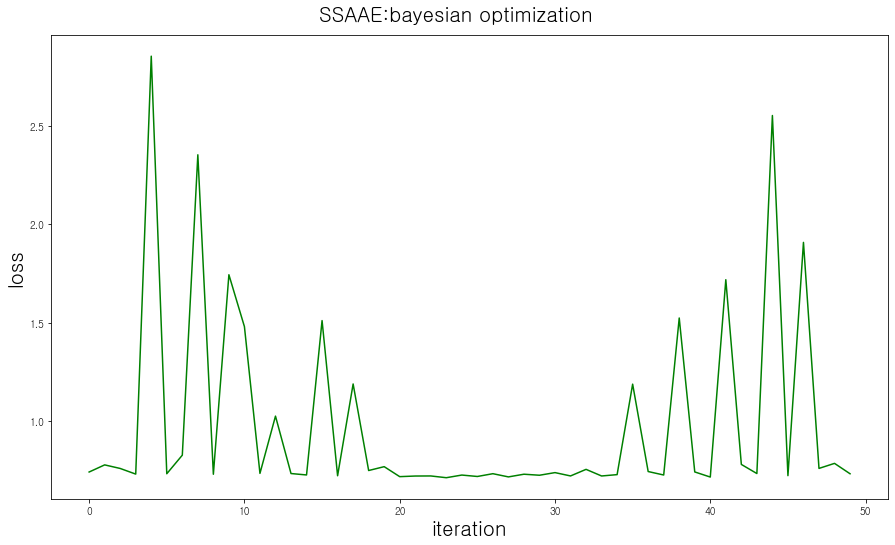

In [5]:
fig, ax = plt.subplots(figsize = (15,8))
plt.plot(search_loss, color = 'green')
plt.suptitle('SSAAE:bayesian optimization', fontsize = 20)
fig.subplots_adjust(top=0.93)
plt.ylabel('loss', fontsize = 20)
plt.xlabel('iteration', fontsize = 20)

In [6]:
#fine tuning
result_loss = []
model_saved = []
hp_1_list = np.argsort(np.array(search_loss))[:10]
for idx3 in tqdm(hp_1_list):
    count_lr = 0
    temp_loss = 10000
    es = 0
    
    trial = trials.trials[idx3]['misc']['vals']
    bn = True if trial['BN'][0] == 0 else False
    noise = {'dropout' : True, 'gaussian_noise' : False, 'dropout_rate' : trial['dropout_rate'][0]} if trial['gaussian_noise_rate'] == [] else {'dropout' : False, 'gaussian_noise' : True, 'stddev' : trial['gaussian_noise_rate']}
    
    ssaae = SSAAE(int(trial['n_nodes'][0]), int(trial['latent_dim'][0]), X_train.shape[1], y_categories, batch_normalization = bn, **noise)
    r_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001 * trial['lr'][0], momentum = .9)
    ss_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * trial['lr'][0], momentum = .9)
    d_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * trial['lr'][0], momentum = .1)
    g_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * trial['lr'][0], momentum = .1)
    ckpt = tf.train.Checkpoint(ssaae = ssaae, r_optimizer = r_optimizer, ss_optimizer = ss_optimizer, d_optimizer = d_optimizer, g_optimizer = g_optimizer)
    
    ckpt.restore(save_path_list[idx3])
    ssaae = ckpt.ssaae
    r_optimizer = ckpt.r_optimizer
    r_optimizer.lr = r_optimizer.lr / 10.
    ss_optimizer = ckpt.ss_optimizer
    ss_optimizer.lr = ss_optimizer.lr / 10.
    d_optimizer = ckpt.d_optimizer
    d_optimizer.lr = d_optimizer.lr / 10.
    g_optimizer = ckpt.g_optimizer
    g_optimizer.lr = g_optimizer.lr / 10.
    
    for j in range(1000):
        train_classification_loss = []
        for i in range(int(len(X_train) / mb_size)):
            #preprocessing
            #mini batch 구성하고 label여부로 minibatch 내에서 구분
            x_batch_train = X_train[i * mb_size:(i+1)*mb_size]
            y_batch_train = y_train[i * mb_size:(i+1)*mb_size]
            mask = tf.math.is_nan(y_batch_train)
            x_unlabeled = tf.boolean_mask(x_batch_train, mask)
            x_labeled = tf.boolean_mask(x_batch_train, ~mask)
            y_labeled = tf.boolean_mask(y_batch_train, ~mask)
            y_labeled = tf.keras.utils.to_categorical(y_labeled, num_classes = y_categories)
            true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = y_categories)

            #train
            r, dz, dy, gz, gy, s = train_step(ssaae, x_batch_train, x_labeled, x_unlabeled, y_batch_train, y_labeled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer)
            train_classification_loss.append(s)
            
        train_classification_loss = np.mean(train_classification_loss)
        
        #test
        true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = y_categories)
        test_reconstruction, test_discriminator_z, test_discriminator_y, test_generator_z, test_generator_y, test_classification, test_accuracy = test_step(ssaae, X_test, y_test, true_output_y)
        
        #earlystopping
        if temp_loss < test_classification:
            es = es + 1
            if es == 10:
                break
        else:
            es = 0
            temp_loss = test_classification
            save_path = ckpt.save(f'D:/early_stopping_finetuning/hp_set_{idx3}/tf_ckpts')
        
        print(f'epoch : {j}, train_loss : {train_classification_loss}, test_loss : {test_classification}, test_acc : {test_accuracy}, es : {es}')

                
    result_loss.append(temp_loss)
    ckpt.restore(save_path)
    save_path = ckpt.save(f'best_model/hp_{idx3}/tf_ckpts')
    model_saved.append(save_path)
    print(f'hp_set_{idx3} result : {temp_loss}')
    print('--------------------------------------------------------------------------------------------------------------------------------------------')
    
    del ssaae
    gc.collect()
    K.clear_session()
    tf.compat.v1.reset_default_graph() 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

epoch : 0, train_loss : 0.6452906727790833, test_loss : 0.7147013545036316, test_acc : 0.6436033844947815, es : 0
epoch : 1, train_loss : 0.6374897956848145, test_loss : 0.7155793309211731, test_acc : 0.6438237428665161, es : 1
epoch : 2, train_loss : 0.6489967703819275, test_loss : 0.7171910405158997, test_acc : 0.6440486907958984, es : 2
epoch : 3, train_loss : 0.650185227394104, test_loss : 0.7161996364593506, test_acc : 0.6442554593086243, es : 3
epoch : 4, train_loss : 0.6469021439552307, test_loss : 0.7158704400062561, test_acc : 0.6444594860076904, es : 4
epoch : 5, train_loss : 0.6443908214569092, test_loss : 0.716077446937561, test_acc : 0.6446681618690491, es : 5
epoch : 6, train_loss : 0.6433095932006836, test_loss : 0.7157996296882629, test_acc : 0.644874095916748, es : 6
epoch : 7, train_loss : 0.643958330154419, test_loss : 0.716096818447113, test_acc : 0.6450846195220947, es : 7
epoch : 8, train_loss : 0.6393383145332336, test_loss : 0.7166538238525391, test_acc : 0.6452

 10%|████████▏                                                                         | 1/10 [03:49<34:29, 229.94s/it]

hp_set_23 result : 0.7147013545036316
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.5367912650108337, test_loss : 0.7233574986457825, test_acc : 0.6580676436424255, es : 0
epoch : 1, train_loss : 0.5225517153739929, test_loss : 0.7296745181083679, test_acc : 0.6592592597007751, es : 1
epoch : 2, train_loss : 0.5166947245597839, test_loss : 0.7334549427032471, test_acc : 0.6603999733924866, es : 2
epoch : 3, train_loss : 0.5077438354492188, test_loss : 0.731024980545044, test_acc : 0.6613247990608215, es : 3
epoch : 4, train_loss : 0.5069416165351868, test_loss : 0.7360024452209473, test_acc : 0.662057638168335, es : 4
epoch : 5, train_loss : 0.5026214122772217, test_loss : 0.755023717880249, test_acc : 0.6626983880996704, es : 5
epoch : 6, train_loss : 0.4923604428768158, test_loss : 0.7503781914710999, test_acc : 0.663409948348999, es : 6
epoch : 7, train_loss : 0.4

 20%|████████████████▍                                                                 | 2/10 [07:46<31:12, 234.05s/it]

hp_set_40 result : 0.7233574986457825
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.5537965893745422, test_loss : 0.7142088413238525, test_acc : 0.6521921753883362, es : 0
epoch : 1, train_loss : 0.5504359602928162, test_loss : 0.7138620615005493, test_acc : 0.6529240012168884, es : 0
epoch : 2, train_loss : 0.5548762679100037, test_loss : 0.713786780834198, test_acc : 0.6535327434539795, es : 0
epoch : 3, train_loss : 0.5512335896492004, test_loss : 0.7143852114677429, test_acc : 0.6541110873222351, es : 1
epoch : 4, train_loss : 0.5484238862991333, test_loss : 0.7147659659385681, test_acc : 0.6546341180801392, es : 2
epoch : 5, train_loss : 0.5451840162277222, test_loss : 0.7150688171386719, test_acc : 0.6552116274833679, es : 3
epoch : 6, train_loss : 0.5390547513961792, test_loss : 0.7179726362228394, test_acc : 0.6557364463806152, es : 4
epoch : 7, train_loss : 

 30%|████████████████████████▌                                                         | 3/10 [12:15<29:08, 249.76s/it]

hp_set_27 result : 0.713786780834198
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.6682426333427429, test_loss : 0.719243586063385, test_acc : 0.6402619481086731, es : 0
epoch : 1, train_loss : 0.6562401652336121, test_loss : 0.7200219631195068, test_acc : 0.640528678894043, es : 1
epoch : 2, train_loss : 0.6694269180297852, test_loss : 0.7217117547988892, test_acc : 0.6407644152641296, es : 2
epoch : 3, train_loss : 0.6726052165031433, test_loss : 0.7204833030700684, test_acc : 0.6410229206085205, es : 3
epoch : 4, train_loss : 0.6669816970825195, test_loss : 0.7198278903961182, test_acc : 0.6412860751152039, es : 4
epoch : 5, train_loss : 0.6655558347702026, test_loss : 0.7203240990638733, test_acc : 0.6415451169013977, es : 5
epoch : 6, train_loss : 0.6649467349052429, test_loss : 0.7196782827377319, test_acc : 0.641791582107544, es : 6
epoch : 7, train_loss : 0.6

 40%|████████████████████████████████▊                                                 | 4/10 [16:09<24:22, 243.71s/it]

hp_set_20 result : 0.719243586063385
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.6553993225097656, test_loss : 0.7201834917068481, test_acc : 0.6367871761322021, es : 0
epoch : 1, train_loss : 0.648111879825592, test_loss : 0.7203245759010315, test_acc : 0.637156069278717, es : 1
epoch : 2, train_loss : 0.6588387489318848, test_loss : 0.7207459211349487, test_acc : 0.6375947594642639, es : 2
epoch : 3, train_loss : 0.6599060893058777, test_loss : 0.7201211452484131, test_acc : 0.6379715800285339, es : 0
epoch : 4, train_loss : 0.6596233248710632, test_loss : 0.7192884683609009, test_acc : 0.6383269429206848, es : 0
epoch : 5, train_loss : 0.6571545004844666, test_loss : 0.7196432948112488, test_acc : 0.638674259185791, es : 1
epoch : 6, train_loss : 0.6541921496391296, test_loss : 0.7192990183830261, test_acc : 0.6390137076377869, es : 2
epoch : 7, train_loss : 0.6

 50%|█████████████████████████████████████████                                         | 5/10 [21:27<22:31, 270.24s/it]

hp_set_25 result : 0.7192884683609009
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.6676926016807556, test_loss : 0.7201454639434814, test_acc : 0.6418989896774292, es : 0
epoch : 1, train_loss : 0.6615510582923889, test_loss : 0.7197491526603699, test_acc : 0.6424999833106995, es : 0
epoch : 2, train_loss : 0.6689279675483704, test_loss : 0.7203176617622375, test_acc : 0.6430214643478394, es : 1
epoch : 3, train_loss : 0.6713894009590149, test_loss : 0.7185541391372681, test_acc : 0.6435057520866394, es : 0
epoch : 4, train_loss : 0.6692487597465515, test_loss : 0.7184537053108215, test_acc : 0.6440113186836243, es : 0
epoch : 5, train_loss : 0.6664817929267883, test_loss : 0.7191416025161743, test_acc : 0.6445370316505432, es : 1
epoch : 6, train_loss : 0.6636513471603394, test_loss : 0.7180206179618835, test_acc : 0.6450091004371643, es : 0
epoch : 7, train_loss :

 60%|█████████████████████████████████████████████████▏                                | 6/10 [27:28<20:04, 301.11s/it]

hp_set_21 result : 0.7180206179618835
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.573366105556488, test_loss : 0.7255527973175049, test_acc : 0.6537566184997559, es : 0
epoch : 1, train_loss : 0.5513684749603271, test_loss : 0.7253719568252563, test_acc : 0.6552020311355591, es : 0
epoch : 2, train_loss : 0.5443271994590759, test_loss : 0.7312930226325989, test_acc : 0.656521737575531, es : 1
epoch : 3, train_loss : 0.5363854765892029, test_loss : 0.7480692267417908, test_acc : 0.6572685241699219, es : 2
epoch : 4, train_loss : 0.5333818793296814, test_loss : 0.7566965818405151, test_acc : 0.658133327960968, es : 3
epoch : 5, train_loss : 0.5253257751464844, test_loss : 0.7536279559135437, test_acc : 0.6586751937866211, es : 4
epoch : 6, train_loss : 0.5174374580383301, test_loss : 0.7395175695419312, test_acc : 0.6593003869056702, es : 5
epoch : 7, train_loss : 0.

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [31:37<14:12, 284.19s/it]

hp_set_33 result : 0.7253719568252563
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.6812137365341187, test_loss : 0.7227213382720947, test_acc : 0.6327732801437378, es : 0
epoch : 1, train_loss : 0.6706522703170776, test_loss : 0.7234495282173157, test_acc : 0.6330824494361877, es : 1
epoch : 2, train_loss : 0.6822378039360046, test_loss : 0.7246153950691223, test_acc : 0.6333422064781189, es : 2
epoch : 3, train_loss : 0.6866340637207031, test_loss : 0.7241770625114441, test_acc : 0.6336331367492676, es : 3
epoch : 4, train_loss : 0.6816263198852539, test_loss : 0.7236712574958801, test_acc : 0.6339195370674133, es : 4
epoch : 5, train_loss : 0.6805896162986755, test_loss : 0.7239654660224915, test_acc : 0.6342100501060486, es : 5
epoch : 6, train_loss : 0.6796058416366577, test_loss : 0.7235997319221497, test_acc : 0.6344961524009705, es : 6
epoch : 7, train_loss :

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [35:26<08:53, 266.66s/it]

hp_set_22 result : 0.7227213382720947
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.5587953925132751, test_loss : 0.713787853717804, test_acc : 0.6528241038322449, es : 0
epoch : 1, train_loss : 0.5500191450119019, test_loss : 0.7147538065910339, test_acc : 0.6538222432136536, es : 1
epoch : 2, train_loss : 0.5505185127258301, test_loss : 0.7149629592895508, test_acc : 0.6547436118125916, es : 2
epoch : 3, train_loss : 0.5432997345924377, test_loss : 0.7178725600242615, test_acc : 0.6556378602981567, es : 3
epoch : 4, train_loss : 0.5400202870368958, test_loss : 0.7182233333587646, test_acc : 0.6564682722091675, es : 4
epoch : 5, train_loss : 0.5372627973556519, test_loss : 0.7192659378051758, test_acc : 0.6570881009101868, es : 5
epoch : 6, train_loss : 0.5294659733772278, test_loss : 0.7217411398887634, test_acc : 0.6578888893127441, es : 6
epoch : 7, train_loss : 

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [39:12<04:14, 254.03s/it]

hp_set_31 result : 0.713787853717804
--------------------------------------------------------------------------------------------------------------------------------------------
epoch : 0, train_loss : 0.5602654814720154, test_loss : 0.7220705151557922, test_acc : 0.6623569130897522, es : 0
epoch : 1, train_loss : 0.5492196679115295, test_loss : 0.7224293351173401, test_acc : 0.6630392074584961, es : 1
epoch : 2, train_loss : 0.5413166284561157, test_loss : 0.7247006297111511, test_acc : 0.6636508107185364, es : 2
epoch : 3, train_loss : 0.5336295366287231, test_loss : 0.7257272005081177, test_acc : 0.664413571357727, es : 3
epoch : 4, train_loss : 0.5313718318939209, test_loss : 0.7249621152877808, test_acc : 0.6651051044464111, es : 4
epoch : 5, train_loss : 0.524738609790802, test_loss : 0.7283784747123718, test_acc : 0.6654970645904541, es : 5
epoch : 6, train_loss : 0.5185657739639282, test_loss : 0.7259806394577026, test_acc : 0.665925920009613, es : 6
epoch : 7, train_loss : 0.5

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [43:07<00:00, 258.77s/it]

hp_set_16 result : 0.7220705151557922
--------------------------------------------------------------------------------------------------------------------------------------------


In [7]:
best_hp = trials.trials[hp_1_list[np.argsort(result_loss)][0]]['misc']['vals']
best_hp

{'BN': [1],
 'dropout_rate': [],
 'gaussian_noise_rate': [0.17670034533525095],
 'latent_dim': [14.0],
 'lr': [48.0],
 'n_nodes': [600.0],
 'noise': [1]}

In [8]:
bn = True if best_hp['BN'][0] == 0 else False
noise = {'dropout' : True, 'gaussian_noise' : False, 'dropout_rate' : best_hp['dropout_rate'][0]} if best_hp['gaussian_noise_rate'] == [] else {'dropout' : False, 'gaussian_noise' : True, 'stddev' : best_hp['gaussian_noise_rate']}
ssaae = SSAAE(int(best_hp['n_nodes'][0]), int(best_hp['latent_dim'][0]), X_train.shape[1], y_categories, batch_normalization = bn, **noise)
r_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001 * best_hp['lr'][0], momentum = .9)
ss_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * best_hp['lr'][0], momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * best_hp['lr'][0], momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001 * best_hp['lr'][0], momentum = .1)
ckpt = tf.train.Checkpoint(ssaae = ssaae, r_optimizer = r_optimizer, ss_optimizer = ss_optimizer, d_optimizer = d_optimizer, g_optimizer = g_optimizer)

ckpt.restore(model_saved[np.argsort(result_loss)[0]])
ssaae = ckpt.ssaae
ssaae.encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2572)]       0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 2572)         0           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_hidden_1 (Dense)        (None, 600)          1543800     gaussian_noise[0][0]             
__________________________________________________________________________________________________
encoder_hidden_2 (Dense)        (None, 600)          360600      encoder_hidden_1[0][0]           
______________________________________________________________________________________________

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(tf.argmax(ssaae.encoder.predict(X_test)[1], axis = 1), tf.argmax(y_test, axis = 1))

C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


0.6766666666666666

In [14]:
ssaae.encoder.save('bestclassifier.h5')

In [7]:
org = pd.read_csv('result_data.csv')
labeled, unlabeled = org.loc[org.label.notna(),:], org.loc[org.label.isna(),:]
X_train, X_test, y_train, y_test = train_test_split(labeled.loc[:,[x for x in labeled.columns if x != 'label']], labeled['label'], test_size = .2, shuffle = True, stratify = labeled['label'], random_state = 42)

In [16]:
y_test

22717    0.0
58373    1.0
7132     1.0
29365    2.0
57777    1.0
        ... 
34492    1.0
271      1.0
35216    0.0
8327     0.0
77553    0.0
Name: label, Length: 900, dtype: float64

In [17]:
sl_classifier = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = [X_train.shape[1]]),
    tf.keras.layers.Dense(600, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(600, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(3, activation = 'softmax', kernel_initializer = 'glorot_normal')
])
sl_classifier.summary()
opt = tf.keras.optimizers.SGD(learning_rate = .0048, momentum = .9)
sl_classifier.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

sl_classifier.fit(X_train, y_train, epochs= 100, validation_data=(X_test, y_test), callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 600)               1543800   
_________________________________________________________________
dense_1 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1803      
Total params: 1,906,203
Trainable params: 1,906,203
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
  7/113 [>.............................] - ETA: 0s - loss: 1.0192 - accuracy: 0.4732

C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


113/113 [==============================] - 1s 10ms/step - loss: 0.8335 - accuracy: 0.6003 - val_loss: 0.7712 - val_accuracy: 0.6444
Epoch 2/100
  1/113 [..............................] - ETA: 1s - loss: 0.7682 - accuracy: 0.7500

C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


113/113 [==============================] - 1s 10ms/step - loss: 0.7272 - accuracy: 0.6747 - val_loss: 0.7320 - val_accuracy: 0.6489
Epoch 3/100
113/113 [==============================] - 1s 10ms/step - loss: 0.6886 - accuracy: 0.6942 - val_loss: 0.7289 - val_accuracy: 0.6611
Epoch 4/100
113/113 [==============================] - 1s 9ms/step - loss: 0.6505 - accuracy: 0.7083 - val_loss: 0.7536 - val_accuracy: 0.6489
Epoch 5/100
113/113 [==============================] - 1s 9ms/step - loss: 0.6207 - accuracy: 0.7297 - val_loss: 0.7630 - val_accuracy: 0.6433
Epoch 6/100
113/113 [==============================] - 1s 9ms/step - loss: 0.5953 - accuracy: 0.7400 - val_loss: 0.7357 - val_accuracy: 0.6567
Epoch 7/100
113/113 [==============================] - 1s 10ms/step - loss: 0.5701 - accuracy: 0.7472 - val_loss: 0.7317 - val_accuracy: 0.6689
Epoch 8/100
113/113 [==============================] - 1s 9ms/step - loss: 0.5599 - accuracy: 0.7619 - val_loss: 0.7632 - val_accuracy: 0.6678
Epoch 9/

In [18]:
sl_classifier.evaluate(X_test, y_test)

29/29 [==============================] - 0s 6ms/step - loss: 0.7211 - accuracy: 0.6867


C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


[0.7210869789123535, 0.6866666674613953]

In [19]:
param_space = {
    'max_depth' : hp.quniform('max_depth', 2, 30, 1),
    'subsample' : hp.uniform('subsample', 0.5,1),
    'colsample_bytree' : hp.uniform('colsample_bytree',0.5, 1),
    'eta' : hp.uniform('eta', 0.01, 0.3),
    'min_child_weight' : hp.quniform('min_child_weight',1,10,1),
    'alpha' : hp.uniform('alpha',0,30)
}

def objective(params):
    params = {'max_depth' : int(params['max_depth']),
             'subsample' : params['subsample'],
             'colsample_bytree' : params['colsample_bytree'],
             'eta' : params['eta'],
              'min_child_weight' : int(params['min_child_weight']),
              'alpha' : params['alpha'],
             'objective' : 'multi:softmax',
              'num_class' : 3,
              'n_estimators' : 10000
             }
    clf = xgb.XGBClassifier(seed = 42, **params)
    hist = clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric = 'mlogloss', eval_set = [(X_test, y_test)], verbose = 0)
    return {'loss' : hist.best_score, 'iteration' : hist.best_iteration, 'status' : STATUS_OK, 'model' : hist}

trials = Trials()
best = fmin(fn=objective, space=param_space, 
            max_evals=50, 
            rstate=np.random.RandomState(42), 
            algo=tpe.suggest,
           trials = trials)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\soymi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



100%|██████████████████████████████████████████████████████████| 50/50 [36:40<00:00, 44.00s/trial, best loss: 0.663101]


In [20]:
search_loss = []
for trial in trials.trials:
    search_loss.append(trial['result']['loss'])
np.argsort(np.array(search_loss))[0]

39

Text(0.5, 0, 'iteration')

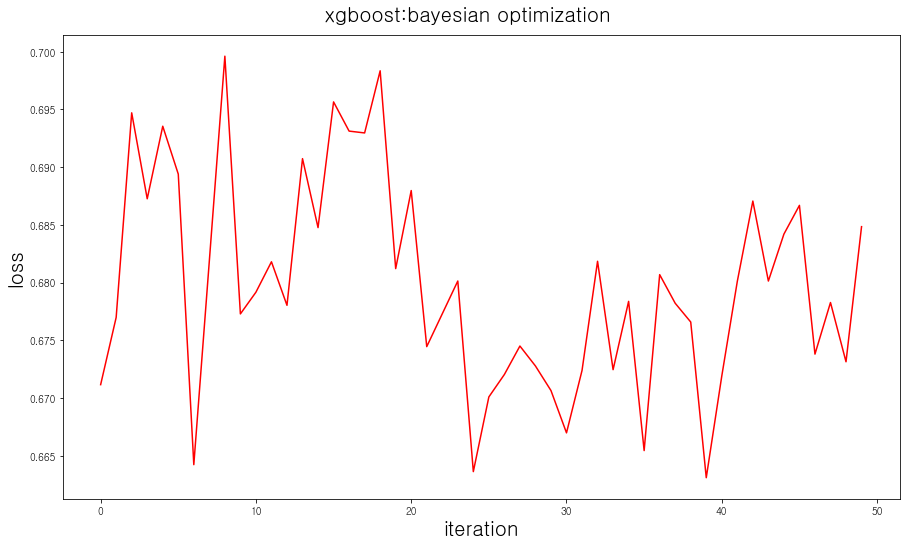

In [21]:
fig, ax = plt.subplots(figsize = (15,8))
plt.plot(search_loss, color = 'red')
plt.suptitle('xgboost:bayesian optimization', fontsize = 20)
fig.subplots_adjust(top=0.93)
plt.ylabel('loss', fontsize = 20)
plt.xlabel('iteration', fontsize = 20)

In [22]:
trials.trials[np.argsort(np.array(search_loss))[0]]

{'state': 2,
 'tid': 39,
 'spec': None,
 'result': {'loss': 0.663101,
  'iteration': 87,
  'status': 'ok',
  'model': XGBClassifier(alpha=12.2021306942957, base_score=0.5, booster='gbtree',
                colsample_bylevel=1, colsample_bynode=1,
                colsample_bytree=0.8182386447269433, eta=0.11878300651475956,
                gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.118783005,
                max_delta_step=0, max_depth=14, min_child_weight=5, missing=nan,
                monotone_constraints='()', n_estimators=10000, n_jobs=16,
                num_class=3, num_parallel_tree=1, objective='multi:softprob',
                random_state=42, reg_alpha=12.2021303, reg_lambda=1,
                scale_pos_weight=None, seed=42, subsample=0.9069262222363192,
                tree_method='exact', validate_parameters=1, ...)},
 'misc': {'tid': 39,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idx

In [23]:
best_clf = trials.trials[np.argsort(np.array(search_loss))[0]]['result']['model']

In [24]:
accuracy_score(best_clf.predict(X_test), y_test)

0.7111111111111111

In [25]:
joblib.dump(best_clf, 'best_xgbmodel.pkl')

['best_xgbmodel.pkl']

<h3>시각화</h3>

In [26]:
best_clf = joblib.load('best_xgbmodel.pkl')

In [27]:
X_train

pages  translated         0         1         2         3         4  \
18183  0.360469           0 -0.251525 -0.215816  0.038600 -0.152537 -0.267639   
14320  0.999739           1 -0.215634  0.014797 -0.198947 -0.187494 -0.250669   
51712  0.167482           1  0.089288 -0.044282  0.050131 -0.232326 -0.235261   
47694  0.414747           0  0.124043 -0.153223 -0.247805 -0.200377 -0.247419   
9966  -0.411479           0 -0.208072 -0.162869  0.032849 -0.247289 -0.240723   
...         ...         ...       ...       ...       ...       ...       ...   
22540  0.149390           0 -0.125709 -0.159421  0.121836 -0.231720 -0.260393   
15866  0.239852           0 -0.192886 -0.269322 -0.057207 -0.211797 -0.259215   
5967   4.003101           1 -0.245472 -0.190237  0.091188 -0.122997 -0.229488   
4720  -0.706990           0 -0.252827 -0.109321  0.141969 -0.265558 -0.181453   
21505  0.674073           1 -0.261978 -0.217114 -0.120283 -0.257499 -0.270133   

              5         6         7  ...  0.0  1.0  2.0  3.0  4.0  5.0  6.0  \
18183 -0.082124 -0.163264 -0.258025  ...    0    0    0    0    1    0    0   
14320 -0.026207 -0.194702 -0.270504  ...    0    0    0    1    0    0    0   
51712 -0.182584 -0.060631 -0.253931  ...    0    0    0    0    0    0    0   
47694 -0.260196 -0.010789 -0.276551  ...    0    0    0    1    0    0    0   
9966  -0.239380  0.420940 -0.221565  ...    0    0    0    0    1    0    0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
22540  0.291932 -0.192989 -0.196144  ...    0    0    0    1    0    0    0   
15866  0.075522 -0.229063 -0.240427  ...    0    0    0    1    0    0    0   
5967  -0.240499 -0.049100 -0.257642  ...    0    0    0    1    0    0    0   
4720  -0.180080 -0.092181 -0.214147  ...    0    0    0    0    0    0    0   
21505  0.399499  0.093017 -0.221632  ...    0    0    0    0    0    0    0   

       7.0  8.0  9.0  
18183    0    0    0  
14320    0    0    0  
51712    0    1    0  
47694    0    0    0  
9966     0    0    0  
...    ...  ...  ...  
22540    0    0    0  
15866    0    0    0  
5967     0    0    0  
4720     0    1    0  
21505    0    1    0  

[3600 rows x 2572 columns]

In [28]:
def get_fi_sum(x):
    pages = 0.
    translated = 0.
    title = 0.
    image = 0.
    subject = 0.

    for k,v in x.items():
        if k == 'pages':
            pages = pages + v
        elif k == 'translated':
            translated = translated + v
        elif k[:4] == 'bert':
            title = title + v
        elif k[-2:] == '.0':
            subject = subject + v
        else:
            image = image + v

    arr = np.array([pages, translated, title, image, subject])
    arr = arr/np.sum(arr)
    return pd.DataFrame({'column' : ['pages','translated','title','image','subject'], 'feature_importance' : arr, 'color' : [plt.cm.tab10(x) for x in range(len(arr))]}).sort_values('feature_importance', ascending = False)

In [29]:
gain = get_fi_sum(best_clf.get_booster().get_score(importance_type = 'gain'))
weight = get_fi_sum(best_clf.get_booster().get_score(importance_type = 'weight'))
cover = get_fi_sum(best_clf.get_booster().get_score(importance_type = 'cover'))

In [30]:
gain

column  feature_importance  \
3       image            0.697588   
2       title            0.281726   
4     subject            0.011537   
0       pages            0.008187   
1  translated            0.000962   

                                               color  
3  (0.8392156862745098, 0.15294117647058825, 0.15...  
2  (0.17254901960784313, 0.6274509803921569, 0.17...  
4  (0.5803921568627451, 0.403921568627451, 0.7411...  
0  (0.12156862745098039, 0.4666666666666667, 0.70...  
1  (1.0, 0.4980392156862745, 0.054901960784313725...

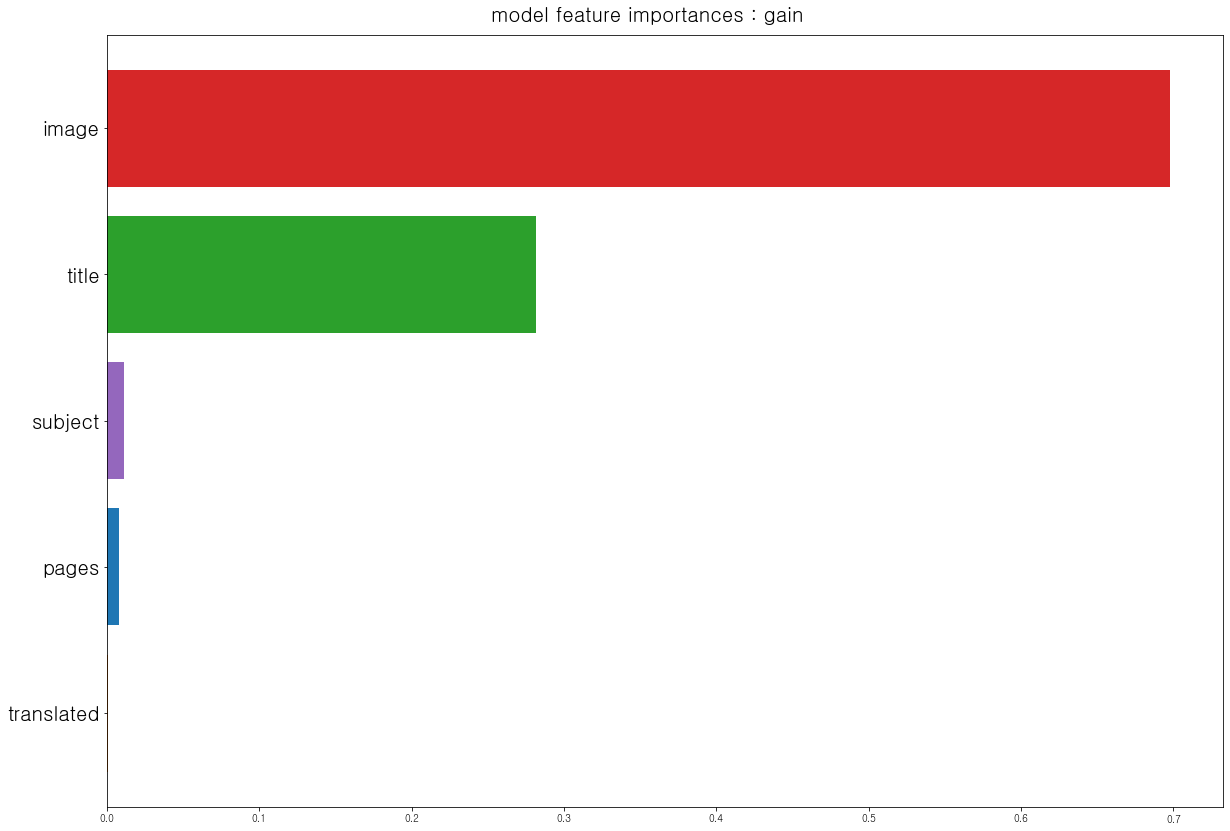

In [31]:
fig, ax = plt.subplots(figsize = (20, 13))
ax.barh(range(len(gain)), gain.feature_importance, color = gain.color)
plt.yticks([x for x in range(len(gain))], gain.column, fontsize = 20)
plt.gca().invert_yaxis()
plt.suptitle('model feature importances : gain', fontsize=20)
fig.subplots_adjust(top=0.95)

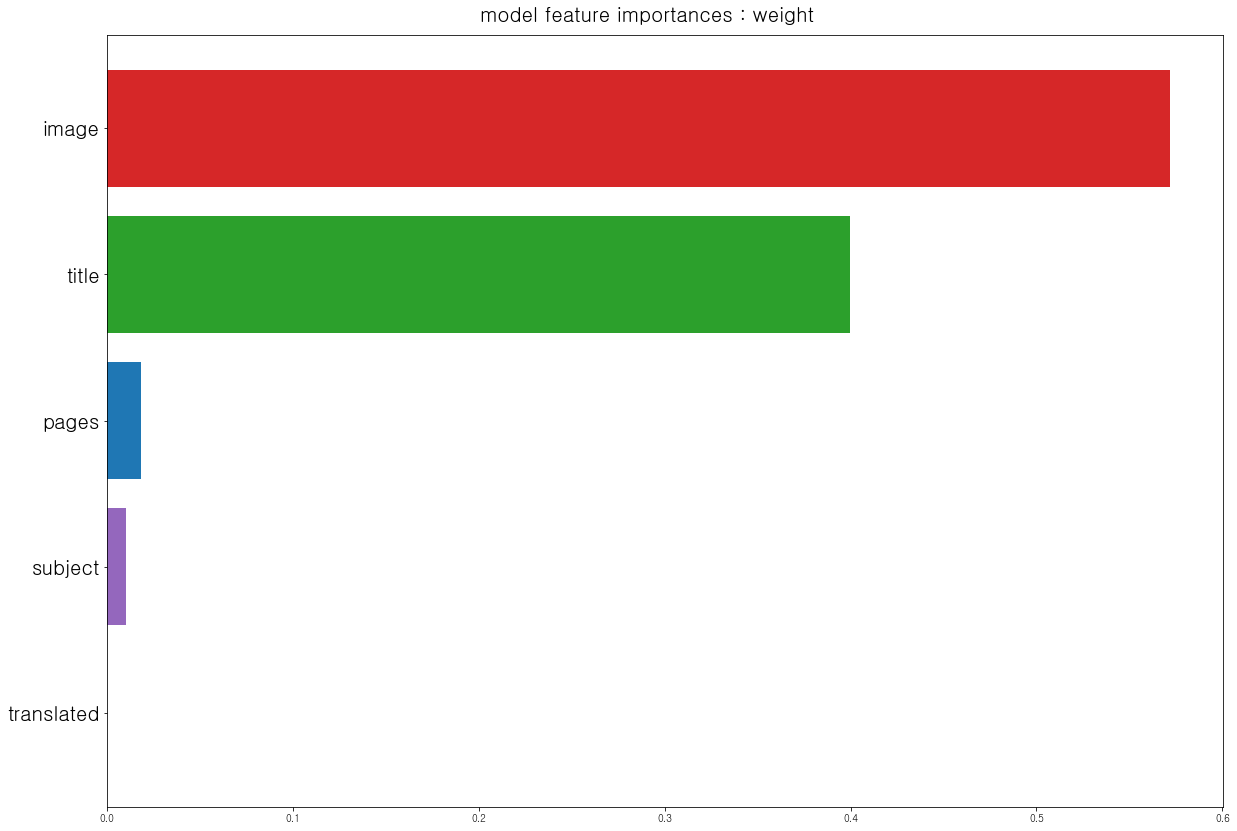

In [32]:
fig, ax = plt.subplots(figsize = (20, 13))
ax.barh(range(len(gain)), weight.feature_importance, color = weight.color)
plt.yticks([x for x in range(len(gain))], weight.column, fontsize = 20)
plt.gca().invert_yaxis()
plt.suptitle('model feature importances : weight', fontsize=20)
fig.subplots_adjust(top=0.95)

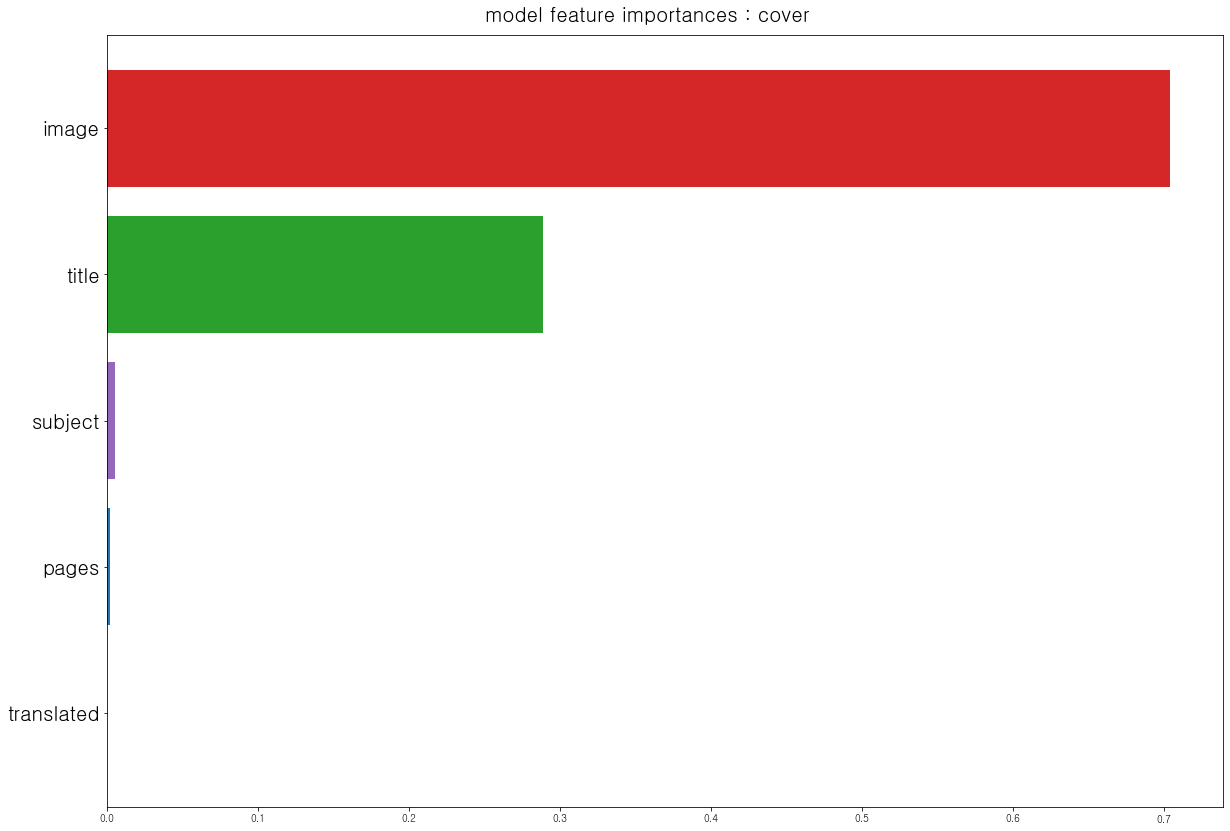

In [33]:
fig, ax = plt.subplots(figsize = (20, 13))
ax.barh(range(len(gain)), cover.feature_importance, color = cover.color)
plt.yticks([x for x in range(len(gain))], cover.column, fontsize = 20)
plt.gca().invert_yaxis()
plt.suptitle('model feature importances : cover', fontsize=20)
fig.subplots_adjust(top=0.95)

In [34]:
from sklearn.inspection import permutation_importance

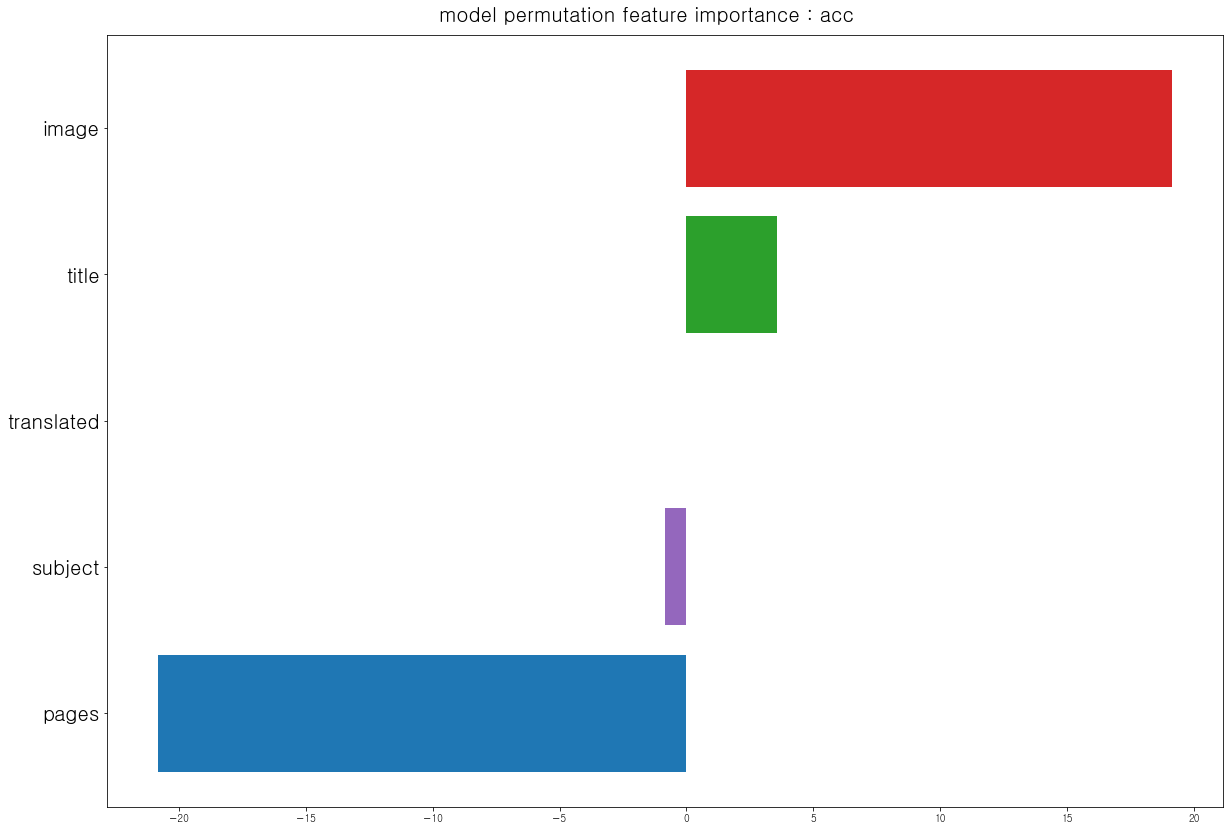

In [35]:
perm_importance = permutation_importance(best_clf, X_test, y_test, n_repeats=10, random_state = 42, scoring = 'accuracy')

pages = 0.
translated = 0.
title = 0.
image = 0.
subject = 0.
for k,v in zip(X_test.columns, perm_importance['importances_mean'].tolist()):
    if k == 'pages':
        pages = pages + v
    elif k == 'translated':
        translated = translated + v
    elif k[:4] == 'bert':
        title = title + v
    elif k[-2:] == '.0':
        subject = subject + v
    else:
        image = image + v
arr = np.array([pages,translated,title,image,subject])
arr = arr / np.sum(arr)
tst = pd.DataFrame({'column' : ['pages','translated','title','image','subject'], 'feature_importance' : arr, 'color' : [plt.cm.tab10(x) for x in range(len(arr))]}).sort_values('feature_importance', ascending = False)

fig, ax = plt.subplots(figsize = (20, 13))
ax.barh(range(len(gain)), tst.feature_importance, color = tst.color)
plt.yticks([x for x in range(len(gain))], tst.column, fontsize = 20)
plt.gca().invert_yaxis()
plt.suptitle('model permutation feature importance : acc', fontsize=20)
fig.subplots_adjust(top=0.95)

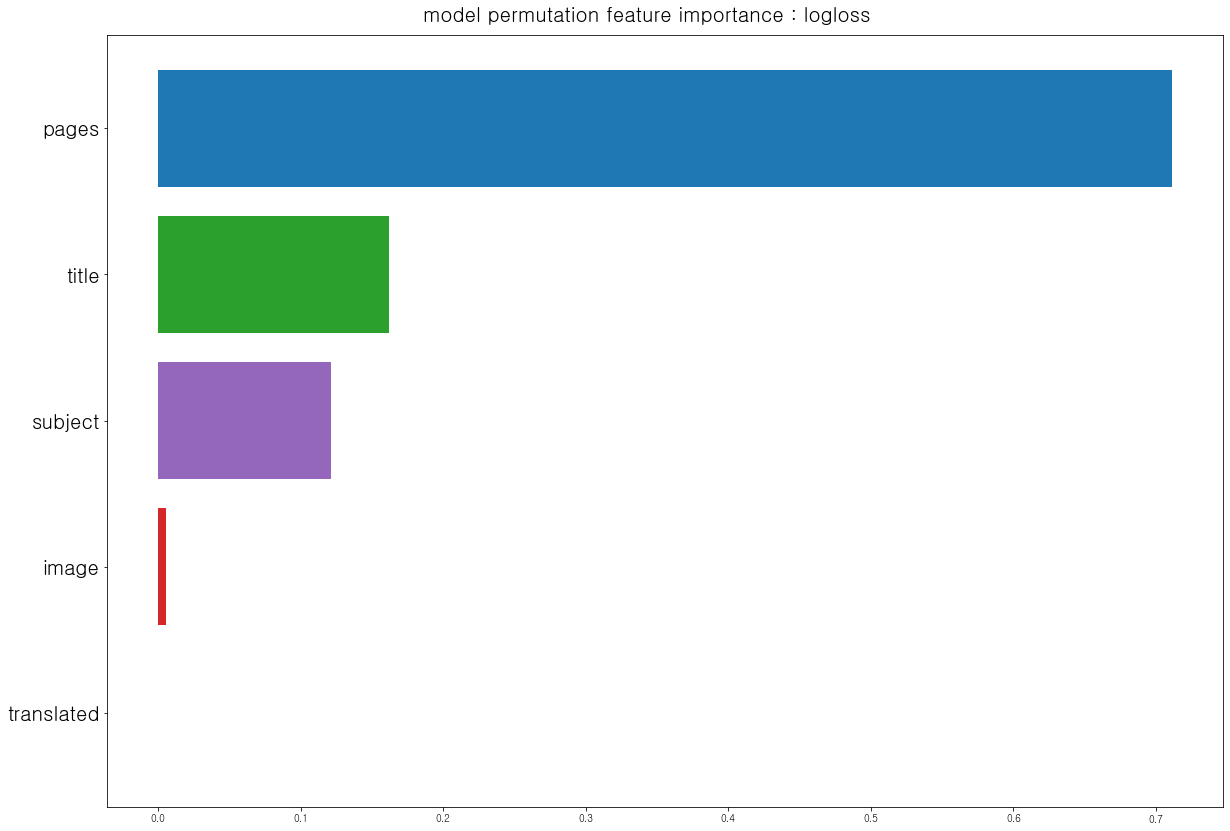

In [36]:
perm_importance = permutation_importance(best_clf, X_test, y_test, n_repeats=10, random_state = 42, scoring = 'neg_log_loss')

pages = 0.
translated = 0.
title = 0.
image = 0.
subject = 0.
for k,v in zip(X_test.columns, perm_importance['importances_mean'].tolist()):
    if k == 'pages':
        pages = pages + v
    elif k == 'translated':
        translated = translated + v
    elif k[:4] == 'bert':
        title = title + v
    elif k[-2:] == '.0':
        subject = subject + v
    else:
        image = image + v
arr = np.array([pages,translated,title,image,subject])
arr = arr / np.sum(arr)
tst = pd.DataFrame({'column' : ['pages','translated','title','image','subject'], 'feature_importance' : arr, 'color' : [plt.cm.tab10(x) for x in range(len(arr))]}).sort_values('feature_importance', ascending = False)

fig, ax = plt.subplots(figsize = (20, 13))
ax.barh(range(len(gain)), tst.feature_importance, color = tst.color)
plt.yticks([x for x in range(len(gain))], tst.column, fontsize = 20)
plt.gca().invert_yaxis()
plt.suptitle('model permutation feature importance : logloss', fontsize=20)
fig.subplots_adjust(top=0.95)

권장도서목록이랑 비교하고 얼마나 일치하는가도 비교?  

ISBN을 받으면 XGBoost prediction을 반환하는 pipeline 구축.

In [8]:
class user_predictor(object):
    def __init__(self, oa_key, jn_key):
        self.tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
        model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
        token_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_word_ids')
        mask_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_masks')
        segment_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_segment')
        bert_outputs = model([token_inputs, mask_inputs, segment_inputs])[1]
        self.title_converter = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], bert_outputs)
        self.image_converter = tf.keras.models.load_model('effb4.h5')
        self.page_scaler = joblib.load('scaler_pages.pickle')
        self.xgb_classifier = joblib.load('best_xgbmodel.pkl')
        self.oa_key = oa_key
        self.jn_key = jn_key
        
    def predict(self, isbn):
        title, title_image_url, pages, major_subject, author = self.get_information_from_api(isbn)
            
        #title
        title = self.title_preprocess(title)
        title = self.title_converter.predict(title)[0].tolist()
        
        #img
        try:
            img = urllib.request.urlretrieve(title_image_url)
            img = tf.keras.preprocessing.image.load_img(img[0], target_size = (64, 64))
            img = np.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis = 0)
            img = tf.keras.applications.efficientnet.preprocess_input(img)
        except:
            raise ValueError('이미지 정보가 잘못되어 예측할 수 없습니다.')
        img = self.image_converter.predict(img)[0].tolist()
        
        #page
        pages = self.get_pages(pages)
        pages = self.page_scaler.transform([[pages]])[0]
        pages = pages.tolist()
        
        #subject
        major_subject = [1 if int(major_subject) == x else 0 for x in range(10)]
        
        #translated
        translated = [1 if (False if author.find('옮김') == -1 else True)or(False if author.find('옮긴') == -1 else True) else 0]
        
        x_ = pd.DataFrame([pages + translated + img + title + major_subject]) 
        y_hat = self.xgb_classifier.predict(x_)
        return int(y_hat[0])
        
        
    def get_information_from_api(self, isbn):
        try:
            url = f'http://seoji.nl.go.kr/landingPage/SearchApi.do?cert_key={self.oa_key}&isbn={isbn}&result_style=json&page_size=1&page_no=1'
            res = requests.get(url).json()
            url2 = f'http://data4library.kr/api/usageAnalysisList?authKey={self.jn_key}&format=json&isbn13={isbn}'
            res2 = requests.get(url2).json()
        except:
            raise ValueError('필요한 정보가 api에 빠져있습니다.')
        try:
            title = res['docs'][0]['TITLE']
        except:
            raise ValueError('필요한 정보가 api에 빠져있습니다.')
        try:
            if res['docs'][0]['TITLE_URL'] == '':
                title_image_url = res2['response']['book']['bookImageURL']
            else:
                title_image_url = res['docs'][0]['TITLE_URL']
        except:
            raise ValueError('필요한 정보가 api에 빠져있습니다.')
        try:
            pages = res['docs'][0]['PAGE']
            if pages == '':
                pages = np.nan
        except:
            raise ValueError('필요한 정보가 api에 빠져있습니다.')
        try:
            major_subject = res['docs'][0]['SUBJECT']
            if major_subject == '':
                major_subject = np.nan
        except:
            major_subject = np.nan
        try:
            author = res['docs'][0]['AUTHOR']
            if author == '':
                raise ValueError('필요한 정보가 api에 빠져있습니다.')
        except:
            raise ValueError('필요한 정보가 api에 빠져있습니다.')
        return title, title_image_url, pages, major_subject, author
            
    def title_preprocess(self, title):
        tokken = np.array(self.tokenizer.encode(title, max_length=128, truncation=True, padding='max_length')).reshape(128,)
        segment = np.zeros(128).astype(int)
        mask = np.where(tokken != 1, 1, 0)
        return [tokken, segment, mask]
    
    def get_pages(self, x):
        try:
            x = re.findall(r'\d+', x)
            if x == []:
                return int(0)
            else:
                return int(max(x))
        except:
            return int(0)

In [9]:
up = user_predictor(oa_key = '', jn_key = '')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.
All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:
dat = pd.read_csv('raw_data.csv', usecols=['isbn','target_1','target_2'])
dat = dat.drop_duplicates('isbn')
dat = dat.dropna()
def target_preprocess(target_1):
    if pd.isna(target_1):
        return np.nan
    elif target_1 in ['초등(8~13)', '영유아(0~5)', '유아(6~7)', '청소년(14~19)']:
        return int(0)
    elif target_1 == '60대 이상':
        return int(2)
    else:
        return int(1)
dat['label'] = dat.target_1.apply(target_preprocess)

C:\Users\soymi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
samp = dat.sample(n = 20, random_state=101)

In [12]:
url = 'http://seoji.nl.go.kr/landingPage/SearchApi.do?cert_key=578ca4ba507631e4a9b621f4029400eac427aaf6071b45611e599387b637b6dc&isbn=9788950996208&result_style=json&page_size=1&page_no=1'
res = requests.get(url).json()

In [14]:
samp

isbn    target_1 target_2  label
2427    9788950996208         40대       남성      1
3022    9788964133149    영유아(0~5)       여성      0
110296  9791191426090         40대       여성      1
348806  9788963710068  청소년(14~19)       여성      0
38617   9788960244986    초등(8~13)       남성      0
98303   9788960172593         20대       남성      1
215517  9791156331445         20대       여성      1
5156    9791191328042         50대       남성      1
10350   9788957821176         40대       남성      1
83386   9788936434106         20대       여성      1
68404   9788952778437         30대       여성      1
1393    9791165794156         40대       여성      1
110633  9788950995317    초등(8~13)       여성      0
18201   9791187064671         50대       남성      1
199019  9791159160295      60대 이상       남성      2
33540   9791159161506      60대 이상       남성      2
101969  9788993242621    영유아(0~5)       남성      0
116667  9791190779258     유아(6~7)       남성      0
3894    9791165215088      60대 이상       여성      2
118173  9788937479953         40대       여성      1

In [15]:
pred = []
for i in range(len(samp)):
    pred.append(up.predict(samp.iloc[i,0]))

C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\soymi\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\soymi\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does 

In [16]:
pred

[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0]

In [17]:
samp.label

2427      1
3022      0
110296    1
348806    0
38617     0
98303     1
215517    1
5156      1
10350     1
83386     1
68404     1
1393      1
110633    0
18201     1
199019    2
33540     2
101969    0
116667    0
3894      2
118173    1
Name: label, dtype: int64

In [18]:
accuracy_score(pred, samp.label)

0.7

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
confusion_matrix(pred, samp.label)

array([[5, 3, 0],
       [1, 8, 2],
       [0, 0, 1]], dtype=int64)

In [21]:
title, url, pages, subject, author = [],[],[],[],[]
for i in range(len(samp)):
    t, u, p, s, a = up.get_information_from_api(samp.iloc[i,0])
    title.append(t)
    url.append(u)
    pages.append(p)
    subject.append(s)
    author.append(a)
pd.DataFrame({'title' : title, 'image' :url, 'pages' : pages, 'subject' : subject, 'author' : author})

title  \
0                            돈의 흐름   
1                       뽀로로와 마법 나라   
2   (애매한 것을 속 시원하게 알려 주는) 알쏭달쏭 상담소   
3                      성균관 유생들의 나날   
4              (빈대 가족의) 덜렁이는 유튜브스타   
5                      드래곤 라자 (양장)   
6     단편소설 쓰기의 모든 것: 궁극의 소설 쓰기 바이블   
7                          위기의 징조들   
8                  (전설로 떠나는)월街의 영웅   
9                          이만큼 가까이   
10                  스스로 마음을 지키는 아이   
11                           구원의 날   
12               이사도라 문, 결혼식에 초대받다   
13                           신의 전쟁   
14                           가족 3번   
15                          전설의 보스   
16                             놀자!   
17                        생각하는 개구리   
18           한 달에 7kg 빠지는 다이어트 레시피   
19                        보건교사 안은영   

                                                image      pages subject  \
0   https://image.aladin.co.kr/product/27382/40/co...     363 p.       3   
1   https://bookthumb-phinf.pstatic.net/cover/135/...      33 p.       8   
2   http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     219 p.       1   
3   https://bookthumb-phinf.pstatic.net/cover/060/...     406 p.       8   
4   https://image.aladin.co.kr/product/20065/22/co...     189 p.       3   
5   http://image.aladin.co.kr/product/280/99/cover...        NaN       8   
6   http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...        352       8   
7   http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     378 p.       3   
8   http://image.aladin.co.kr/product/10764/4/cove...        488       3   
9   http://image.aladin.co.kr/product/3819/1/cover...        NaN       8   
10  http://image.aladin.co.kr/product/10926/18/cov...        292       5   
11  https://image.aladin.co.kr/product/26295/41/co...     287 p.       8   
12  https://image.aladin.co.kr/product/27501/5/cov...     103 p.       8   
13  https://image.aladin.co.kr/product/27515/53/co...     744 p.       9   
14  https://bookthumb-phinf.pstatic.net/cover/112/...  300페이지 내외       8   
15  https://image.aladin.co.kr/product/26980/88/co...     325 p.       8   
16  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...        NaN       8   
17  https://image.aladin.co.kr/product/26397/7/cov...      55 p.       8   
18  https://image.aladin.co.kr/product/26681/91/co...        224       5   
19  http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILE...     293 p.       8   

                                    author  
0                                   전인구 지음  
1                                키즈아이콘 [편]  
2           이케가야 유지 글 ;요시타케 신스케 그림 ;엄혜숙 옮김  
3                                 지은이: 정은궐  
4                          글: 임창호 ;그림: 류수형  
5                                      이영도  
6                       데이먼 나이트 지음, 정아영 옮김  
7   벤 버냉키,티머시 가이트너,헨리 폴슨 주니어 지음 ;마경환 옮김·감수  
8               피터 린치, 존 로스차일드 지음 / 이 건 옮김  
9                                 지은이: 정세랑  
10                                송미경, 김학철  
11                                지은이: 정해연  
12                     해리엇 먼캐스터 지음 ;심연희 옮김  
13                  지은이: 카렌 암스트롱 ;옮긴이: 정영목  
14                                     이원호  
15                                  이원호 지음  
16                                박정섭 글·그림  
17                     이와무라 카즈오 지음 ;박지석 옮김  
18                                저자 : 송혜영  
19                                지은이: 정세랑

In [22]:
url

['https://image.aladin.co.kr/product/27382/40/cover/8950996200_1.jpg',
 'https://bookthumb-phinf.pstatic.net/cover/135/517/13551786.jpg?type=m1&udate=20180525',
 'http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILES_TBL/2021/02/25/9791191426090.jpg',
 'https://bookthumb-phinf.pstatic.net/cover/060/481/06048112.jpg?type=m1&udate=20100913',
 'https://image.aladin.co.kr/product/20065/22/cover/8960244988_1.jpg',
 'http://image.aladin.co.kr/product/280/99/cover/8960172596_1.jpg',
 'http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILES_TBL/6035770_3.jpg',
 'http://seoji.nl.go.kr/fu/ecip/dbfiles/CIP_FILES_TBL/2021/02/02/9791191328042.jpg',
 'http://image.aladin.co.kr/product/10764/4/cover/8957821171_1.jpg',
 'http://image.aladin.co.kr/product/3819/1/cover/8936434101_1.jpg',
 'http://image.aladin.co.kr/product/10926/18/cover/895277843x_1.jpg',
 'https://image.aladin.co.kr/product/26295/41/cover/k392738791_1.jpg',
 'https://image.aladin.co.kr/product/27501/5/cover/895099531x_1.jpg',
 'https://image.aladin

In [ ]:
def get_information_from_api(self, isbn):
    try:
        url = f'http://seoji.nl.go.kr/landingPage/SearchApi.do?cert_key={self.oa_key}&isbn={isbn}&result_style=json&page_size=1&page_no=1'
        res = requests.get(url).json()
        url2 = f'http://data4library.kr/api/usageAnalysisList?authKey={self.jn_key}&format=json&isbn13={isbn}'
        res2 = requests.get(url2).json()
    except:
        raise ValueError('필요한 정보가 api에 빠져있습니다.')
    try:
        title = res['docs'][0]['TITLE']

In [54]:
dat = pd.read_csv('raw_data.csv', usecols=['isbn','target_1','target_2'])
dat = dat.drop_duplicates('isbn')
dat = dat.dropna()

C:\Users\soymi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
dat

isbn    target_1 target_2
16      9791190473613      60대 이상       남성
17      9791167030160      60대 이상       남성
18      9791191769029         50대       여성
19      9791160023176         40대       여성
20      9791166570308         50대       여성
...               ...         ...      ...
377992  9788956600109      60대 이상       남성
378007  9788956600116      60대 이상       남성
378121  9788935659258      60대 이상       남성
379986  9788983717412  청소년(14~19)       여성
380289  9788935659296      60대 이상       남성

[8164 rows x 3 columns]

In [62]:
dat2 = dat.loc[dat.target_1.isin(['30대','40대','50대','60대 이상']),:]
dat2 = dat2.loc[dat2.target_2 == '여성',:]
dat2

isbn target_1 target_2
18      9791191769029      50대       여성
19      9791160023176      40대       여성
20      9791166570308      50대       여성
21      9788965964230      40대       여성
27      9791165216030      50대       여성
...               ...      ...      ...
354828  9788937831652      30대       여성
356659  9788965746300   60대 이상       여성
359315  9791185035901      50대       여성
360850  9788989258452   60대 이상       여성
377440  9788972754671      50대       여성

[2436 rows x 3 columns]

In [69]:
oa_key = '' ###
reader = []
for i in range(len(dat2)):
    isbn = dat2.iloc[i,0]
    try:
        url = f'http://seoji.nl.go.kr/landingPage/SearchApi.do?cert_key={oa_key}&isbn={isbn}&result_style=json&page_size=1&page_no=1'
        res = requests.get(url).json()
        reader.append(res['docs'][0]['EA_ADD_CODE'][0])
    except:
        reader.append(np.nan)

In [70]:
dat2['reader'] = reader
dat2.reader.value_counts()

0    1263
7     851
1     146
6     126
4      32
Name: reader, dtype: int64

In [73]:
dat2.reader.isna().sum()

18

In [74]:
dat3 = dat.loc[dat.target_1.isin(['30대','40대','50대','60대 이상']),:]
dat3 = dat3.loc[dat3.target_2 == '남성',:]
dat3

isbn target_1 target_2
16      9791190473613   60대 이상       남성
17      9791167030160   60대 이상       남성
23      9788993178975   60대 이상       남성
24      9791187297314   60대 이상       남성
32      9791130639321      50대       남성
...               ...      ...      ...
358475  9788936430603   60대 이상       남성
377992  9788956600109   60대 이상       남성
378007  9788956600116   60대 이상       남성
378121  9788935659258   60대 이상       남성
380289  9788935659296   60대 이상       남성

[1543 rows x 3 columns]

In [76]:
oa_key = '' ###
reader = []
for i in range(len(dat3)):
    isbn = dat3.iloc[i,0]
    try:
        url = f'http://seoji.nl.go.kr/landingPage/SearchApi.do?cert_key={oa_key}&isbn={isbn}&result_style=json&page_size=1&page_no=1'
        res = requests.get(url).json()
        reader.append(res['docs'][0]['EA_ADD_CODE'][0])
    except:
        reader.append(np.nan)

In [78]:
dat3['reader'] = reader
dat3.reader.value_counts()

0    1225
1     142
7      62
9      15
6       4
Name: reader, dtype: int64

In [79]:
dat3.reader.isna().sum()

95

In [81]:
best_clf.predict_proba(X_test.iloc[0,:].to_numpy().reshape((1,-1)))

array([[0.94208425, 0.05791577]], dtype=float32)

In [82]:
X_test

pages  translated         0         1         2         3  \
1646    0.227791           0  0.001415 -0.165208  0.339519 -0.240850   
10822   1.403806           1 -0.255532 -0.198309 -0.018557 -0.077043   
25101   2.266217           0 -0.210239 -0.055946 -0.194551 -0.265447   
5464   -1.117088           0 -0.084811 -0.175126 -0.219061 -0.211281   
49016  -0.477818           0 -0.163190 -0.216094 -0.176868 -0.270808   
...          ...         ...       ...       ...       ...       ...   
116754 -0.429572           0 -0.255007  0.193224 -0.046556 -0.264258   
11311  -1.394507           1  0.007010  0.045541 -0.225026 -0.233031   
29814  -0.501942           0 -0.201417  0.073431 -0.023624 -0.246389   
885     0.505210           0 -0.197983 -0.016688 -0.237449 -0.136803   
31472  -0.188338           1 -0.241213 -0.276313 -0.248984 -0.222863   

               4         5         6         7  ...  0.0  1.0  2.0  3.0  4.0  \
1646   -0.261744 -0.136170 -0.051221 -0.255492  ...    0    0    0    1    0   
10822  -0.248348  0.003887 -0.152516 -0.226913  ...    0    0    0    0    0   
25101  -0.259948  0.172864 -0.185117 -0.248162  ...    0    0    0    0    0   
5464   -0.241182 -0.235711  0.155213 -0.182122  ...    0    0    0    0    0   
49016  -0.245031 -0.203918 -0.196540 -0.058942  ...    0    0    0    0    1   
...          ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
116754 -0.234472 -0.191921 -0.032019 -0.215040  ...    0    0    0    0    0   
11311  -0.252476 -0.237176  0.056409 -0.220755  ...    0    0    0    0    0   
29814  -0.252177 -0.235690  0.267207 -0.245089  ...    0    0    0    0    0   
885    -0.253056 -0.099554  0.234765 -0.262596  ...    0    0    0    0    0   
31472  -0.270530 -0.259296  0.057738 -0.227807  ...    0    0    0    0    0   

        5.0  6.0  7.0  8.0  9.0  
1646      0    0    0    0    0  
10822     1    0    0    0    0  
25101     0    0    0    1    0  
5464      0    0    0    1    0  
49016     0    0    0    0    0  
...     ...  ...  ...  ...  ...  
116754    0    1    0    0    0  
11311     0    0    0    1    0  
29814     0    0    0    1    0  
885       0    0    0    0    1  
31472     0    0    0    1    0  

[900 rows x 2572 columns]

In [44]:
import seaborn as sns

In [95]:
dff = pd.DataFrame({'Model' : ['SSAAE','SSAAE','MLP','MLP','XGBoost','XGBoost'], 'Perf.' : ['Loss','Acc','Loss','Acc','Loss','Acc'], 'coef' : [0.713,0.676,0.721,0.686,0.663,0.711]})

C:\Users\soymi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


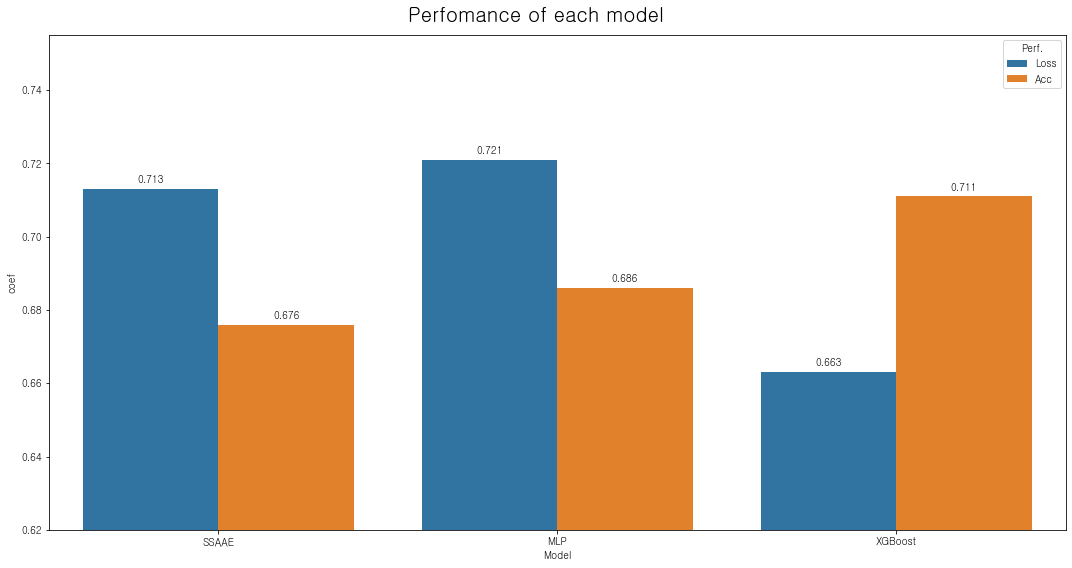

In [96]:
fig, ax = plt.subplots(figsize = (15, 8))
p = sns.barplot(dff.Model, dff.coef, hue=dff['Perf.'])
ax.set_ylim(.62, .755)
plt.suptitle('Perfomance of each model' , fontsize = 20)
plt.tight_layout()

for pp in p.patches:
    p.annotate(format(pp.get_height(), '.3f'), 
                   (pp.get_x() + pp.get_width() / 2., pp.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [93]:
p.patches[0].get_height()

0.731

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [11]:
org = pd.read_csv('result_data.csv')
labeled, unlabeled = org.loc[org.label.notna(),:], org.loc[org.label.isna(),:]

In [12]:
org.label[org.label.isna()] = 3
org.label

<ipython-input-12-8bed009f2217>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  org.label[org.label.isna()] = 3


0         1.0
1         3.0
2         3.0
3         3.0
4         1.0
         ... 
136200    3.0
136201    3.0
136202    3.0
136203    3.0
136204    3.0
Name: label, Length: 136205, dtype: float64

C:\Users\soymi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


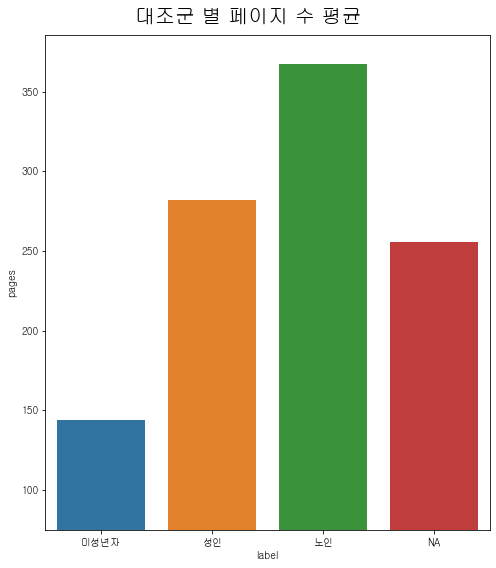

In [155]:
scaler = joblib.load('scaler_pages.pickle')
pages = pd.DataFrame({'pages' : scaler.inverse_transform([org.pages])[0], 'label' : org.label})
pages = pages.groupby('label').mean().reset_index()
pages['label'] = ['미성년자','성인','노인','NA']
fig, ax  = plt.subplots(figsize = (7, 8))
p = sns.barplot(pages.label, pages.pages)
plt.suptitle('대조군 별 페이지 수 평균', fontsize = 20)
plt.ylim(75)
plt.tight_layout()

C:\Users\soymi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


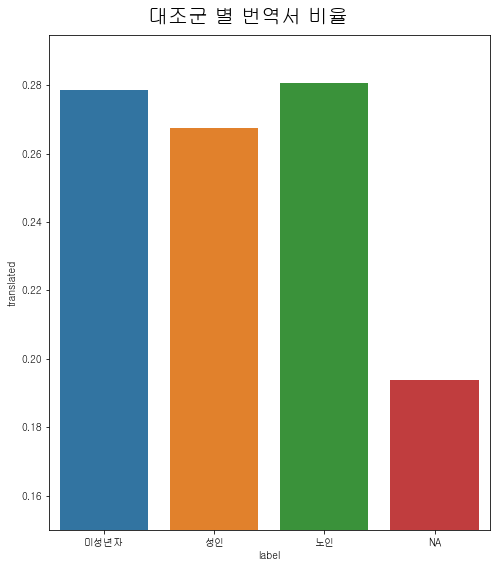

In [154]:
trans = org.loc[:,['translated','label']]
trans = trans.groupby('label').mean().reset_index()
trans['label'] = ['미성년자','성인','노인','NA']
fig, ax  = plt.subplots(figsize = (7, 8))
p = sns.barplot(trans.label, trans.translated)
plt.suptitle('대조군 별 번역서 비율', fontsize = 20)
plt.ylim(.15)
plt.tight_layout()

0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  label
0         0    0    0    1    0    0    0    0    0    0    1.0
1         0    0    0    0    0    0    0    0    0    1    3.0
2         0    0    0    0    0    0    0    0    1    0    3.0
3         0    0    0    0    0    0    0    0    0    1    3.0
4         0    0    0    0    0    0    0    0    1    0    1.0
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...
136200    0    0    0    1    0    0    0    0    0    0    3.0
136201    0    0    0    1    0    0    0    0    0    0    3.0
136202    0    0    0    0    0    0    1    0    0    0    3.0
136203    0    0    1    0    0    0    0    0    0    0    3.0
136204    0    0    0    0    0    0    0    0    0    1    3.0

[136205 rows x 11 columns]

C:\Users\soymi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


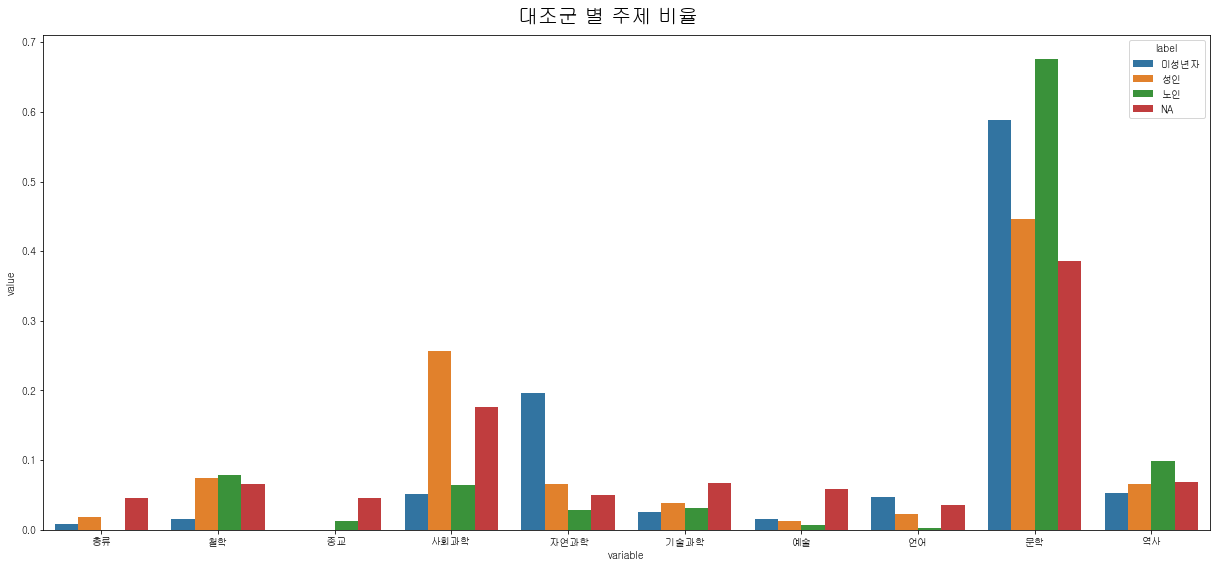

In [97]:
subject = org.loc[:,[x for x in org.columns if x[-2:] == '.0'] + ['label']]
subject = subject.groupby('label').sum()
subject.columns = ['총류', '철학',' 종교', '사회과학',' 자연과학', '기술과학','예술','언어','문학','역사'] 
subject = subject.div(subject.sum(axis=1), axis=0).reset_index()
subject['label'] = ['미성년자','성인','노인','NA']
subject = subject.melt('label')
fig, ax  = plt.subplots(figsize = (17, 8))
p = sns.barplot(subject.variable, subject.value, hue = subject.label)
plt.suptitle('대조군 별 주제 비율', fontsize = 20)
plt.tight_layout()

In [13]:
bert = org.loc[:,[x for x in org.columns if x[:4] == 'bert'] + ['label']]
bert_corr = []
for i in tqdm([0,1,2,3]):
    temp = bert.loc[bert.label == i,:]
    print(len(temp))
    bert_corr.append(temp.loc[:,[x for x in temp.columns if x != 'label']].corr().to_numpy())

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

1654


 25%|█████████████████████                                                               | 1/4 [00:01<00:04,  1.36s/it]

2429


 50%|██████████████████████████████████████████                                          | 2/4 [00:03<00:03,  1.73s/it]

417


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.10s/it]

131705


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:51<00:00, 27.78s/it]


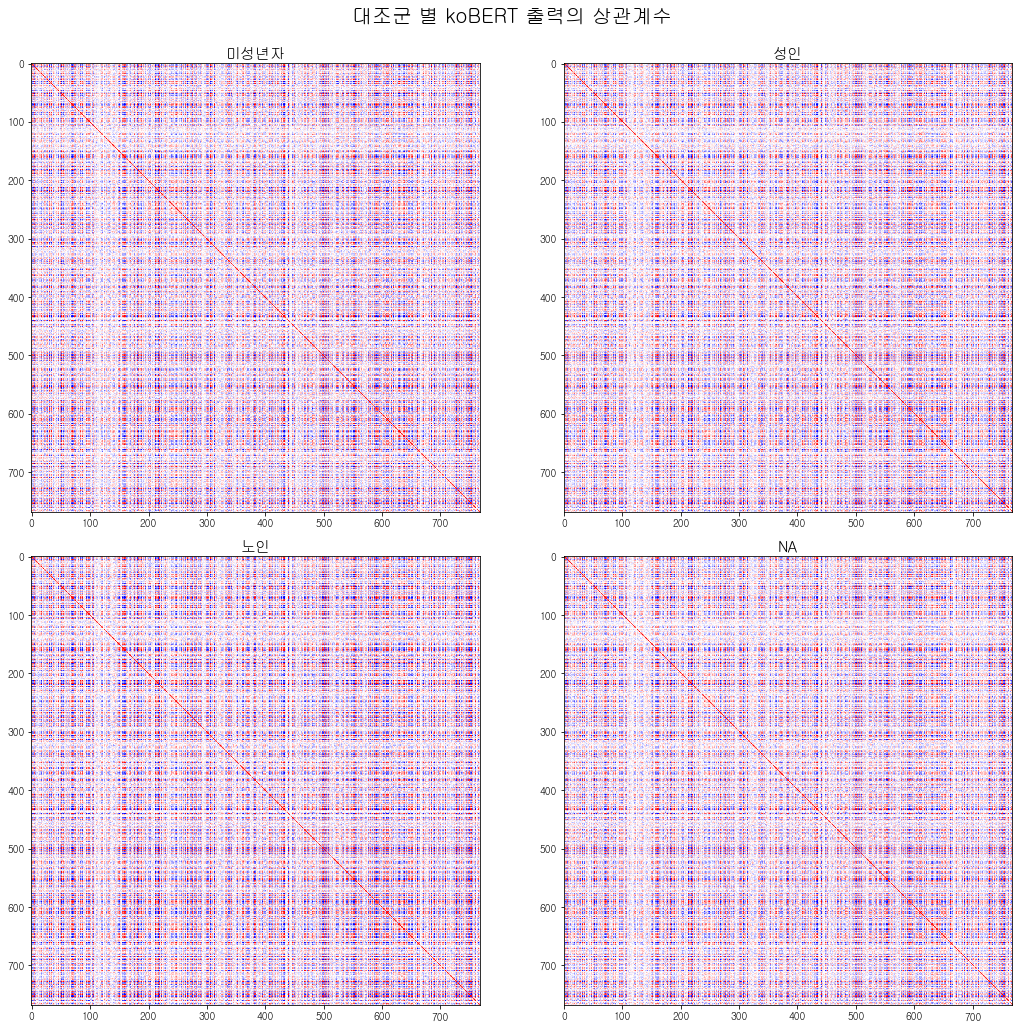

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (15,15))
ll = ['미성년자','성인','노인','NA']
for i in range(4):
    ax[i//2, i%2].imshow(bert_corr[i], cmap = 'bwr', vmin=-.5, vmax=.5)
    ax[i//2,i%2].set_title(f'{ll[i]}', fontsize = 15)
plt.suptitle('대조군 별 koBERT 출력의 상관계수', fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

In [15]:
effnet = org.iloc[:,2:1794]
effnet['label'] = org.label
effnet_corr = []
for i in tqdm([0,1,2,3]):
    temp = effnet.loc[effnet.label == i,:]
    print(len(temp))
    effnet_corr.append(temp.loc[:,[x for x in temp.columns if x != 'label']].corr().to_numpy())

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

1654


 25%|█████████████████████                                                               | 1/4 [00:08<00:25,  8.66s/it]

2429


 50%|██████████████████████████████████████████                                          | 2/4 [00:19<00:19,  9.86s/it]

417


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:06,  6.20s/it]

131705


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [09:59<00:00, 149.91s/it]


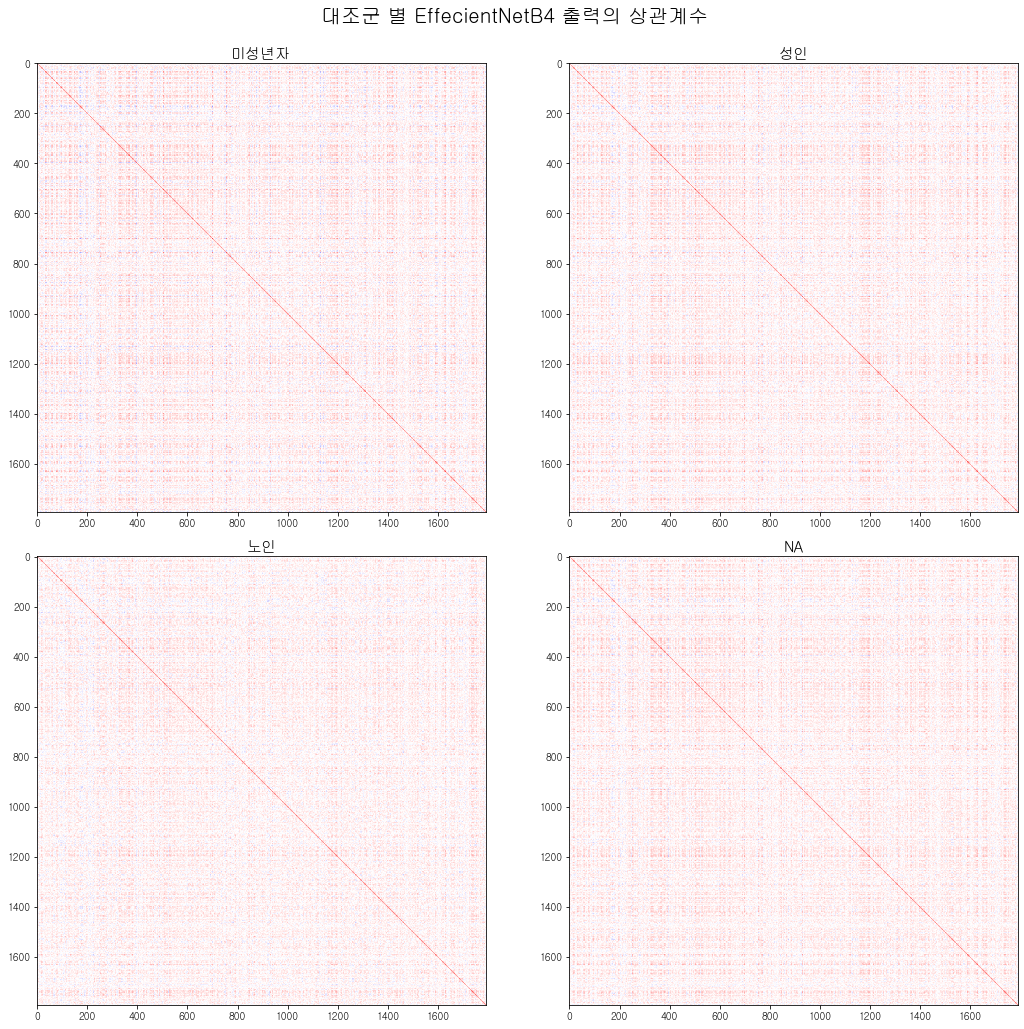

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (15,15))
ll = ['미성년자','성인','노인','NA']
for i in range(4):
    ax[i//2, i%2].imshow(effnet_corr[i], cmap = 'bwr', vmin=-.5, vmax=.5)
    ax[i//2,i%2].set_title(f'{ll[i]}', fontsize = 15)
plt.suptitle('대조군 별 EffecientNetB4 출력의 상관계수', fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

In [19]:
effnet_corr[0].min()

-0.666426302972465